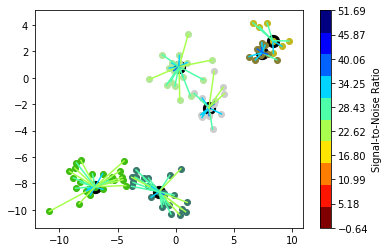

0.7450721263885498
{'Cluster Head': 'client93', 'Members': ['client6', 'client14', 'client19', 'client20', 'client26', 'client28', 'client29', 'client31', 'client41', 'client44', 'client45', 'client50', 'client53', 'client54', 'client55', 'client56', 'client71', 'client72', 'client77', 'client82', 'client86', 'client96', 'client100'], 'SNR': [27.00746142351621, 17.707536275282834, 30.224610464371466, 19.973306443491662, 29.283816191534235, 23.597730666496396, 25.94686253926128, 32.41650360160989, 21.627358703725427, 24.04101464612355, 33.85130769192598, 25.514615509528113, 28.06207741010207, 22.038156698600694, 22.33722605477033, 21.016823301411026, 20.560501002887, 25.716746004156672, 19.359005284278076, 28.584246666505273, 20.10944326462436, 18.854117645557213, 23.093296296933282], 'CSI': [0.7860521645387865, 0.8047004881114117, 0.36641032593583256, 0.24443991215920313, 0.7888780610237429, 0.5563030078669253, 0.45518201998539964, 0.7209401627460353, 0.033380581471241455, 0.3420344729

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/test/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                #params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

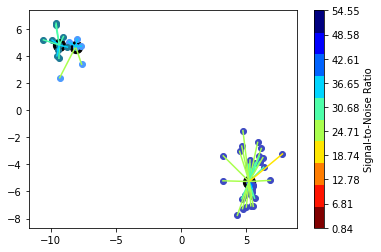

0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.370554


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.173215
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.586294

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.261980
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.965945
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.272715

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310072
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.924158
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.433478

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230751
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.740148
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.194810

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.681208
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.011988

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264979
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.814212
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.296287

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.256578
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.885885
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.026592

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.344282
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.078299
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.552116

Power Allocated= 2.605692174016901
CSI= 0.569

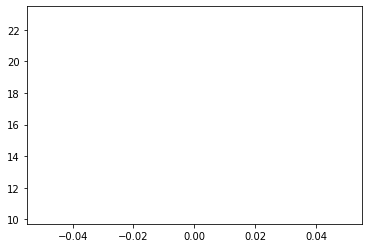

ROUND 0
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309142


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.057945
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.725823

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293588
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.904521
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.282867

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310573
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.143821
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.843303

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307271
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.109459
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.678523

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.093563
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.876810

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.048355
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.286443
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.250775

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.515611
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.616006
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.557447

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.041422
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.887068
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.287800

Power Allocated= 2.605692174016901
CSI= 0.569

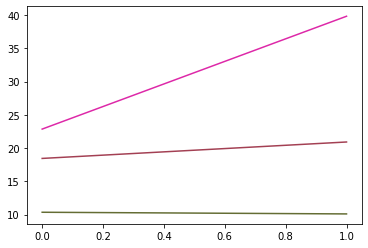

ROUND 1
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299200


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.062104
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.659127

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297037
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.932216
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.426231

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312963
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.033539
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.575565

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.319297
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.970225
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.557138

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.436000
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.921198

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.436581
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.024052
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.212610

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.388249
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.884350
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.430512

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226489
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.455885
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.267354

Power Allocated= 2.605692174016901
CSI= 0.569

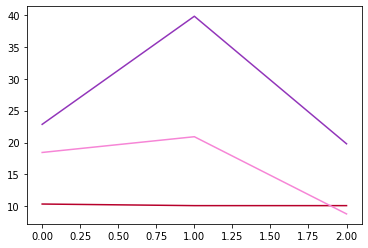

ROUND 2
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303571


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.977788
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.659475

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290403
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.803992
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.372614

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.313789
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.988569
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.653554

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.330864
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.749197
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.070538

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.611061
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.287113

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.482230
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.817531
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.287033

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.481018
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.815929
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.550284

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232169
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.710472
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.259543

Power Allocated= 2.605692174016901
CSI= 0.569

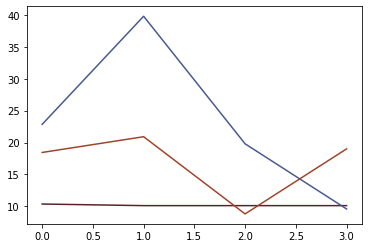

ROUND 3
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295012


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.793526
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.397672

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.283577
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.568003
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.102267

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.315875
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.927749
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.596264

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335127
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.665280
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.222487

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.697241
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.175927

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.743583
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.372902
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.382748

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.503794
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.660282
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.180994

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225046
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.388575
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.013489

Power Allocated= 2.605692174016901
CSI= 0.569

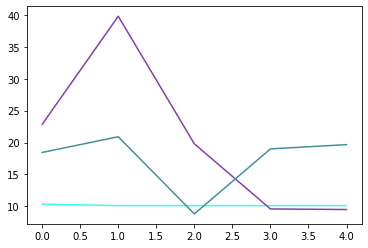

ROUND 4
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281063


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.780040
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.530962

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296418
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.502980
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.107315

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.320986
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.805606
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.464366

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.339743
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.509930
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.349315

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.362428
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.054822

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.714201
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.613550
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.177633

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.617014
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.440802
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.169932

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210142
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.340204
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.104578

Power Allocated= 2.605692174016901
CSI= 0.569

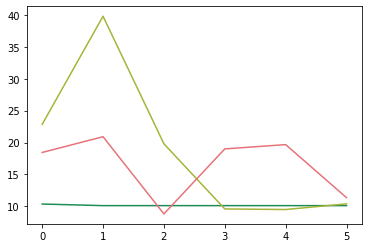

ROUND 5
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291265


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.783854
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.504407

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293199
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.233256
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.940694

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.317480
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.765298
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.518549

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.346498
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.462692
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.283465

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.226627
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.964857

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.797080
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.409082
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.089065

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.620889
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.463589
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.047706

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.178309
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.177187
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.139991

Power Allocated= 2.605692174016901
CSI= 0.569

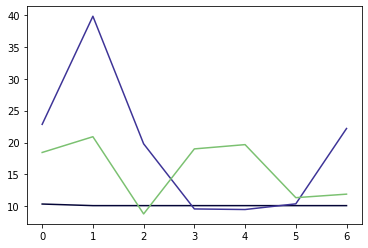

ROUND 6
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281425


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.266846
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.881365

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.347499
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.415799
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.985890

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.241236
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.657822
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.116608


Test set: Average loss for Cluster1 model: 2.4829, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.074676
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.996435

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.046443
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.269332
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.095216

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.741185
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.302895
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.091180

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166342
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.157839
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.994824

Power Allocated= 2.605692174016901
CSI= 0.569

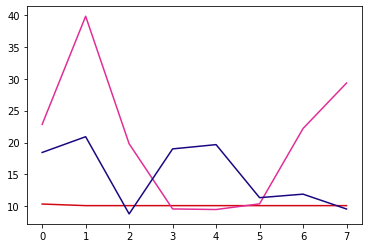

ROUND 7
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309193


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.608846
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.475807

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271924
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.232320
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.066003

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.324422
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.694670
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.647317

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.354750
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.383046
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.086648

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.154956
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.645566

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.197401
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.208851
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.162457

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.720899
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.289403
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.143548

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.042806
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.178822
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.079063

Power Allocated= 2.605692174016901
CSI= 0.569

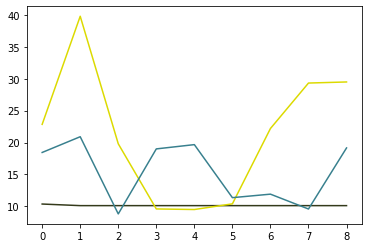

ROUND 8
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286366


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.668810
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.450649

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265666
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.132528
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.082181

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.364077
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.279858
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.099944

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266368
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.881735
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.478973

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.428355
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.041661
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.985312

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.868998
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.267408
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.346261

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.197844
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.022600
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.660658

Power Allocated= 2.605692174016901
CSI= 0.569

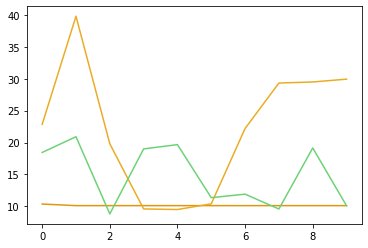

ROUND 9
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.273527


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.570932
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.429070

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263662
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.154540
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.747804

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.362230
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.273747
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.021644

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.250797
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.878046
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.338274

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.405359
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.184005
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.975552

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.889506
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.201778
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.874036

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292661
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.904547
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.763817

Power Allocated= 2.605692174016901
CSI= 0.569

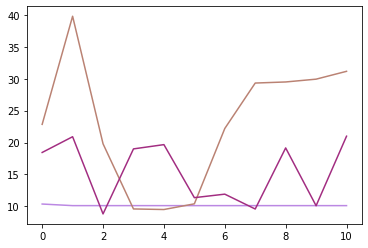

ROUND 10
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286452


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.585876
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.185011

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271265
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.092898
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.475467

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.341022
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.706410
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.446706

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365891
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.217544
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.292293

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.734013
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.339282

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.674740
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.041779
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.974705

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.124385
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.944536
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.941092

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224743
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.961091
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.476202

Power Allocated= 2.605692174016901
CSI= 0.569

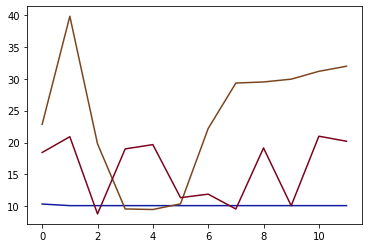

ROUND 11
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.285738


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.553933
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.521144

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264130
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.042976
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.729815

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.339619
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.632653
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.399673

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.370180
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.257218
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.167457

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.604068
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116305

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.558865
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.053777
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.954366

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.027270
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.082866
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.794872

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.077373
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.811519
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.472315

Power Allocated= 2.605692174016901
CSI= 0.569

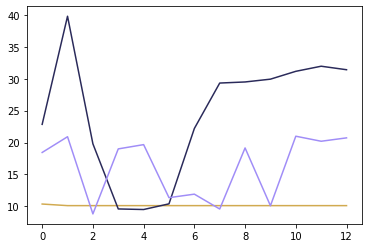

ROUND 12
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287120


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.493423
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.078049

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275873
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.034430
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.668160

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.375001
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.258268
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.320601

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.219444
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.622244
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140601

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.889066
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.057596
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.756158

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.314598
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.874159
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.631393

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.117705
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.634243
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276923

Power Allocated= 2.605692174016901
CSI= 0.569

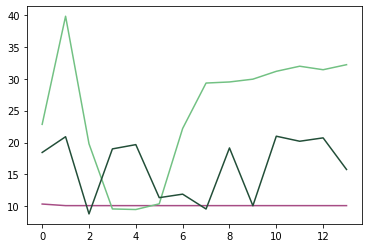

ROUND 13
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278061


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.531445
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.337698

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257239
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.042398
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.996874

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335634
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.600080
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.412577

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.378802
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.168896
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.071027

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291963
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066261

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.691273
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.969962
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.623730

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.667131
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.827248
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.561561

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.209572
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.841433
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169197

Power Allocated= 2.605692174016901
CSI= 0.569

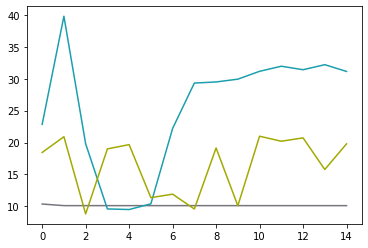

ROUND 14
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304810


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.483450
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.214121

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276289
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.954569
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.452987

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.378602
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.215639
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.089116

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230341
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.383130
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051164

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.925880
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.041580
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.914069

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.355118
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.714168
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.629533

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.464070
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.617083
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185136

Power Allocated= 2.605692174016901
CSI= 0.569

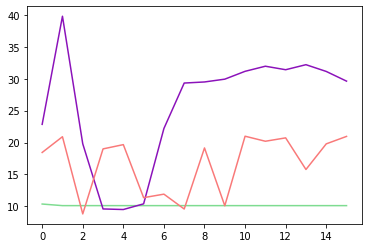

ROUND 15
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.245336


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.921517
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.669749

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.346166
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.577610
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.412219

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.389983
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.195735
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.980632

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247710
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.425853
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.944664


Test set: Average loss for Cluster1 model: 2.85

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347326
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371791

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.132592
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.960777
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.594226

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.473067
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.750313
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422178

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.341764
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.677873
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.603755

Power Allocated= 2.605692174016901
CSI= 0.569

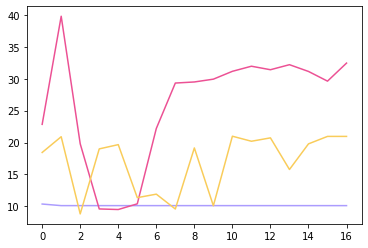

ROUND 16
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292092


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.422473
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.973163

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258165
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.895654
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.401576

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.338759
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.509027
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.398520

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.389538
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.185548
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.848580

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254879
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103125

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.881323
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.835199
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038701

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.612057
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.646086
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.710231

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.222727
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.477374
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.391646

Power Allocated= 2.605692174016901
CSI= 0.569

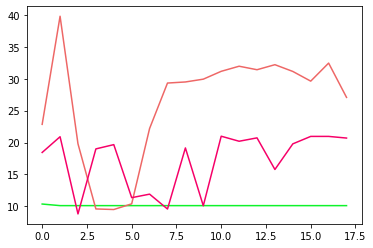

ROUND 17
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286133


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.373593
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.042065

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270272
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.808286
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333161

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365871
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.507710
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.413715

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.392551
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.998090
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.750395

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392522
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246216

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.355510
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.870205
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.886546

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.441828
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.613585
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.440246

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.153225
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.360882
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.428866

Power Allocated= 2.605692174016901
CSI= 0.569

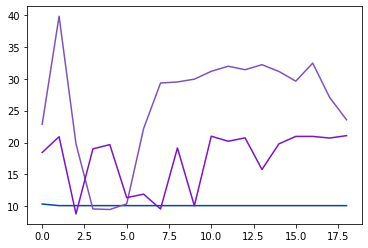

ROUND 18
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289100


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.367224
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.847312

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263508
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.660313
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113004

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.331965
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.501045
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.416964

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.392725
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.134610
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.775344

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186248
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083664

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.289050
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.752261
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.807996

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.679638
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.573713
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326511

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.351032
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.327211
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.419140

Power Allocated= 2.605692174016901
CSI= 0.569

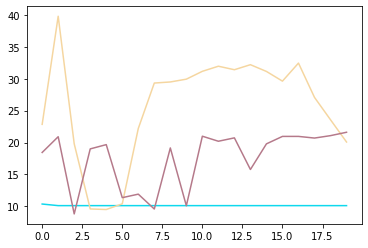

ROUND 19
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280938


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.328481
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.987762

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257895
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.646709
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310710

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.394209
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.971039
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.681183

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217478
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197359
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093802

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.305256
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.666486
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.584452

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.853838
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.504557
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.305967

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198036
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.372242
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.388460

Power Allocated= 2.605692174016901
CSI= 0.569

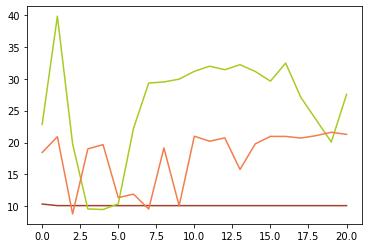

ROUND 20
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264378


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.619058
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.847960

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.400160
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.075919
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.186853

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239565
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.338560
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.979039


Test set: Average loss for Cluster1 model: 3.3096, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192294
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025869

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.867579
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.758598
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.849530

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.509570
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.676055
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.557177

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.178360
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214885
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.183712

Power Allocated= 2.605692174016901
CSI= 0.569

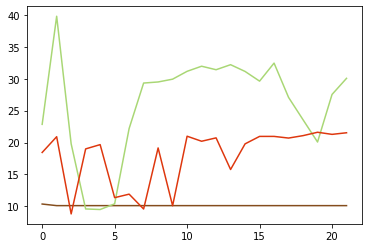

ROUND 21
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298246


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.332506
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.006429

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220606
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.751675
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230501

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.376445
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.504466
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.436834

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.400268
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.026179
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.891519

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212249
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194924

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.658002
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.519947
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.726664

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.770315
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.460603
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294897

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.318285
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323019
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126773

Power Allocated= 2.605692174016901
CSI= 0.569

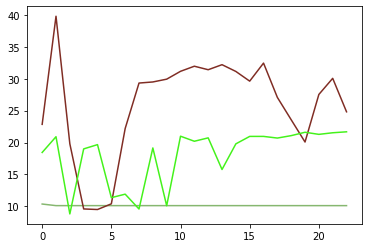

ROUND 22
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306841


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.308071
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.054899

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240280
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.630683
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321663

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.401802
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079977
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.681633

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217604
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191317
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246460

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.144329
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.863205
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.771559

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.023661
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.871824
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.368476

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.536963
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302485
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036125

Power Allocated= 2.605692174016901
CSI= 0.569

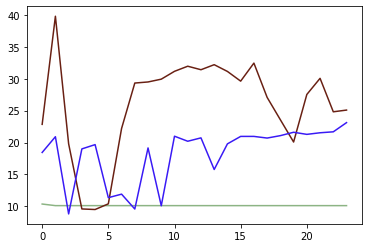

ROUND 23
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271761


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.329798
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.975255

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240305
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.470543
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023355

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365357
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.461807
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.500141

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.398008
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.814421
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.692770

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098479
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142984

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.695443
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.476238
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.588358

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.800507
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.460462
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.438652

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.457839
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234562
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.553107

Power Allocated= 2.605692174016901
CSI= 0.569

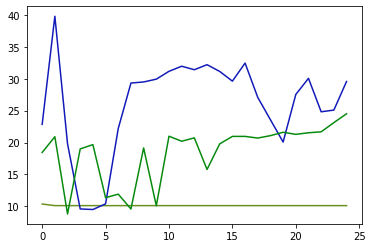

ROUND 24
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294685


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.289075
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.815936

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255142
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.517346
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379122

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365191
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.467721
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.355222

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.401316
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.017065
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.723136

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165426
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061697

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.182118
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.836087
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.708062

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.017598
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.431491
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.406853

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.921103
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132245
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085565

Power Allocated= 2.605692174016901
CSI= 0.569

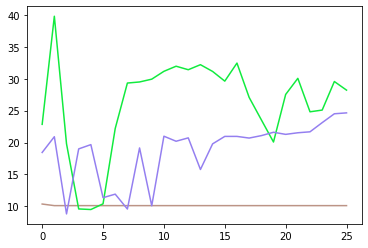

ROUND 25
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267824


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.186943
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.761414

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231122
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.517798
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087069

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.403925
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.778650
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.364148

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213143
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.364534
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057360

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.560968
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.600749
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.552385

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.106367
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.501594
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379848

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240779
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092524
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025137

Power Allocated= 2.605692174016901
CSI= 0.569

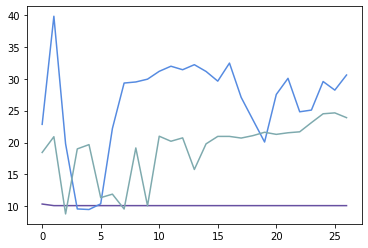

ROUND 26
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.260612


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.618036
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145117

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.403524
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.757174
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.488401

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210401
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.966615
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.574808


Test set: Average loss for Cluster1 model: 3.7406, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129825
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149076

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.868965
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.678118
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.509561

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.387830
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.358244
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.519423

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.179249
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243220
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139468

Power Allocated= 2.605692174016901
CSI= 0.569

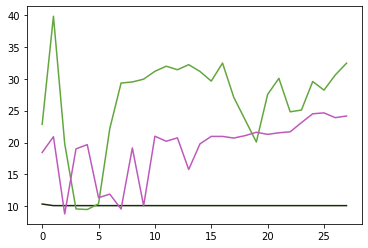

ROUND 27
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258708


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.148081
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.877547

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251171
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.358409
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114468

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365774
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.467123
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.631475

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.404747
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.798310
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310399

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256747
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426545

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.366731
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.533425
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.554353

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.903147
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.609288
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214157

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.397102
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067806
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.361236

Power Allocated= 2.605692174016901
CSI= 0.569

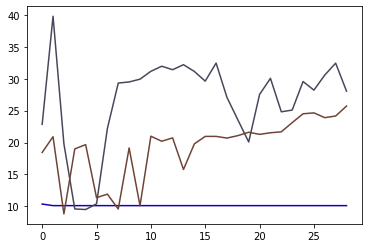

ROUND 28
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265157


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.331034
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.818165

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.249201
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.337766
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125827

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.349127
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.429211
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.478503

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.408592
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.896049
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.403691

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162533
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.595111

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.763223
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.504825
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.493250

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.934454
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.292209
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.512261

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.444197
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302325
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.127160

Power Allocated= 2.605692174016901
CSI= 0.569

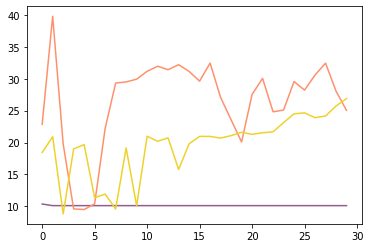

ROUND 29
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301350


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.982854
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.656218

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224592
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.274891
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026355

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.363839
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.404653
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.426128

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.412169
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.681068
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216052

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199994
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133372

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.772144
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.622017
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.581167

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.117239
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400207
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.248944

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278515
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076768
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026240

Power Allocated= 2.605692174016901
CSI= 0.569

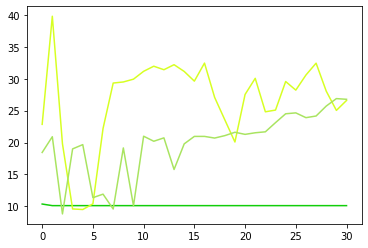

ROUND 30
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272545


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.126849
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.567446

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.241075
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223859
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002941

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.379968
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.448303
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.582056

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.415295
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.646326
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128823

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105791
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006507

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.582279
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.518804
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.434226

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.806136
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291110
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243372

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.570664
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143859
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113151

Power Allocated= 2.605692174016901
CSI= 0.569

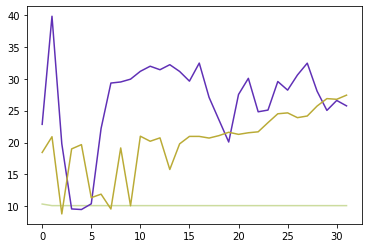

ROUND 31
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282501


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.052851
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.575135

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.233712
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153295
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047020

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365666
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.484017
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.516025

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.416069
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.617039
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100810

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105887
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184640

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.309432
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441357
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.290042

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.850691
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275460
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.257582

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.978586
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080512
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028192

Power Allocated= 2.605692174016901
CSI= 0.569

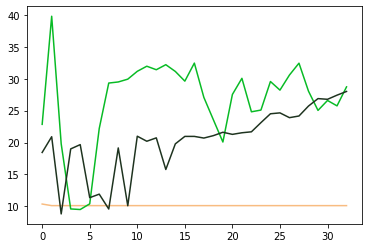

ROUND 32
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278800


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.125433
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.667890

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239676
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191908
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138882

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.353386
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.448511
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.370499

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.415825
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.457949
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125530

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094979
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011108

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.633074
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.445864
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566221

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.049641
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181357
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.579178

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.425940
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072193
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203597

Power Allocated= 2.605692174016901
CSI= 0.569

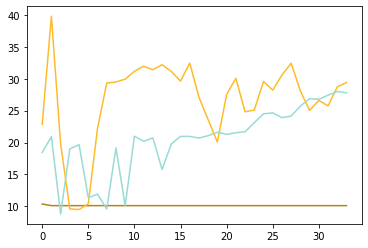

ROUND 33
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282935


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.897894
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422553

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231184
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160045
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047885

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.406130
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.419763
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.466243

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.411772
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.424847
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089292

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104810
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.369194

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.815151
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.553178
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.450351

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.971396
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313127
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265957

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.099785
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104843
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079464

Power Allocated= 2.605692174016901
CSI= 0.569

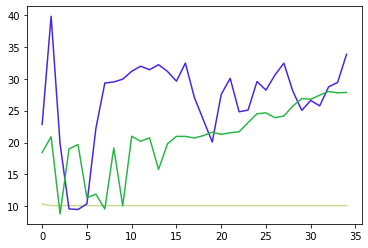

ROUND 34
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278968


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.938136
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.292061

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.279127
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147622
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067368

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.413174
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.421360
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402192

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176451
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077176
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094914

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.536468
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392825
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.545843

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.128216
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253090
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190161

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.194314
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.250105
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199123

Power Allocated= 2.605692174016901
CSI= 0.569

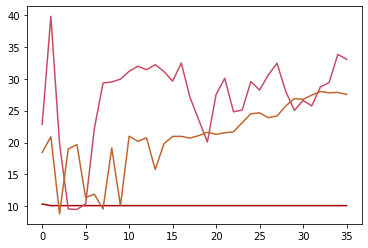

ROUND 35
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268589


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.909843
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210939

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262464
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178544
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123094

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.353734
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.405176
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.530557

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.417843
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.541833
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184556

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.394403
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107603

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 12.272283
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.545488
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.419511

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.419004
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.289261
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262291

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.038626
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078011
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061452

Power Allocated= 2.605692174016901
CSI= 0.56

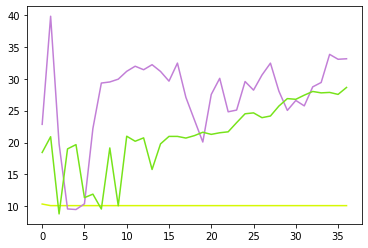

ROUND 36
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271758


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.796576
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276617

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.254687
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130619
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.736657

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.417040
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.299771
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010648

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220600
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145269
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062319

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 11.810608
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.559636
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.613210

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.730551
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157137
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379142

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.879531
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199951
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036315

Power Allocated= 2.605692174016901
CSI= 0.56

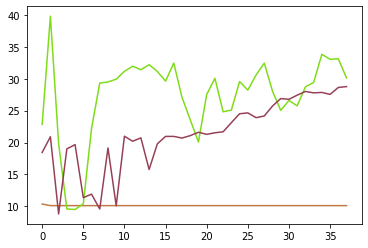

ROUND 37
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.242741


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253429
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025864

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.389412
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.449674
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.493858

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.418187
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450056
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014342

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.219243
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.449241
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179645


Test set: Average loss for Cluster1 model: 4.47

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173418
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217810

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.163849
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.622864
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.544337

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.763558
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302694
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150685

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.032499
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071609
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310693

Power Allocated= 2.605692174016901
CSI= 0.569

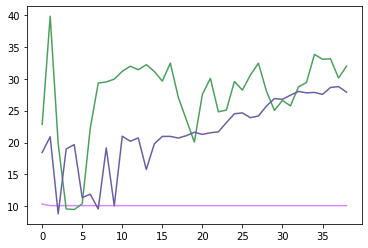

ROUND 38
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.273043


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.797940
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.352316

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.249755
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173610
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025154

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.419339
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.514818
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120964

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206568
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210714
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.649091

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.440045
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441169
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.561143

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.410403
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.262871
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.520646

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.649682
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214375
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038133

Power Allocated= 2.605692174016901
CSI= 0.569

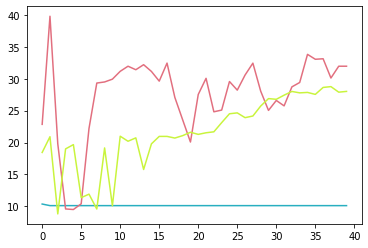

ROUND 39
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.250184


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.682185
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.244959

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252452
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347843
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046941

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.363275
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.423622
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.491131

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.416328
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.299240
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206272

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264142
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.812710

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 10.316082
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.532260
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.373393

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 12.317782
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450346
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.703694

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.671262
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139178
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.287749

Power Allocated= 2.605692174016901
CSI= 0.5

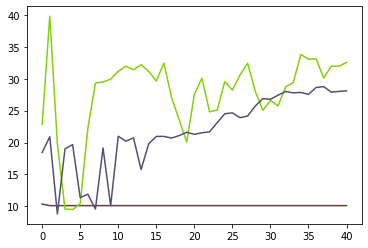

ROUND 40
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304419


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.687505
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.234656

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230913
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135859
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038618

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.387355
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.382886
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.490927

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.414685
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405734
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117395

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123532
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115198

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 10.457927
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.327510
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.576847

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.134404
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.232784
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330933

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.015272
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154996
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052503

Power Allocated= 2.605692174016901
CSI= 0.56

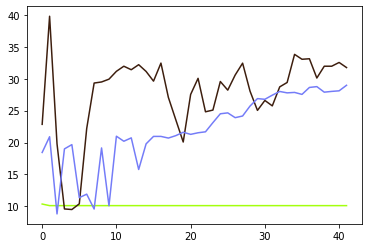

ROUND 41
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.285488


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.733369
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.800846

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246248
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.293369
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167222

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.364146
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.459120
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.538053

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.415700
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285177
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.244050

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083436
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030658

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 12.987613
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.566937
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.612222

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 12.979120
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.568937
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276759

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.059437
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095944
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357980

Power Allocated= 2.605692174016901
CSI= 0.5

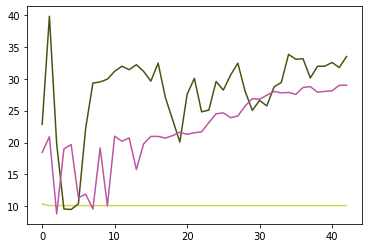

ROUND 42
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263085


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.529196
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.505985

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182578
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209679
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.629646

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.385764
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.436962
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.544449

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.419465
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198396
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040874

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073244
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122598

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 12.728231
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.564039
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316009

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 11.668478
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.393731
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252191

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.378151
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103335
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.368476

Power Allocated= 2.605692174016901
CSI= 0.5

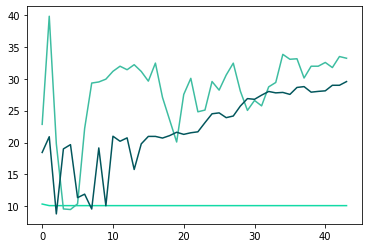

ROUND 43
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258218


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.565919
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.524985

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.211536
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239513
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001571

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.428573
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215945
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.547914

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176390
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185855
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238268

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 14.639847
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.410479
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.405532

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 16.235395
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.437829
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.212282

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.754427
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021187
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061017

Power Allocated= 2.605692174016901
CSI= 0.5

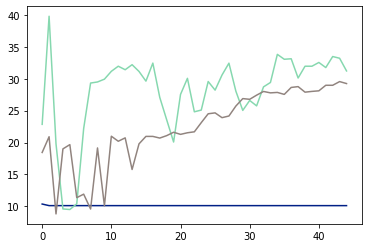

ROUND 44
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269434


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.553935
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173285

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220573
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115351
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.187630

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.356521
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.401961
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.508144

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.419572
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222581
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.678981

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122216
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062641

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 14.903214
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.963354
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.590786

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 17.481796
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328480
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.017979

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.042824
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178452
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029268

Power Allocated= 2.605692174016901
CSI= 0.5

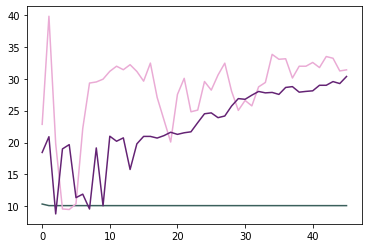

ROUND 45
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.316416


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.492411
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.131866

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223260
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100345
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150652

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.386832
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.395342
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.337354

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.421054
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303450
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.925839

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038826
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.465057

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.733639
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.447542
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.312695

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 19.423815
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302931
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313718

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.460313
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163254
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336642

Power Allocated= 2.605692174016901
CSI= 0.5

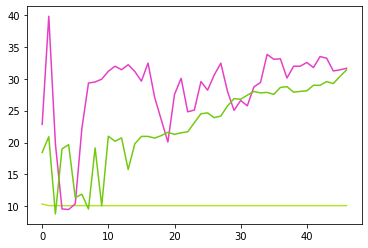

ROUND 46
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258675


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.489701
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.405542

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238226
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091166
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000194

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.411164
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131737
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008661

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203891
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162807
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154993

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 23.149729
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.443123
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236839

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 20.694220
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.536413
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272286

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.743098
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100794
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161309

Power Allocated= 2.605692174016901
CSI= 0.5

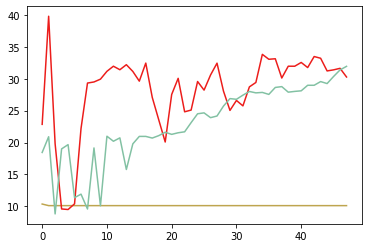

ROUND 47
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290814


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.541000
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.398165

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.202168
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054385
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.245561

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.334099
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.395842
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.343217

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.416243
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220968
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121375

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.338366
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.743297

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.347042
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.296579
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190959

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 23.223152
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317702
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.320243

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.264334
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070074
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104668

Power Allocated= 2.605692174016901
CSI= 0.5

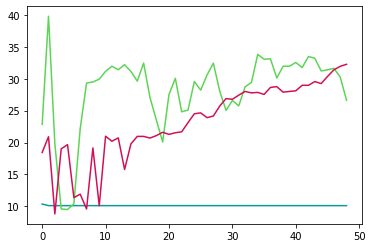

ROUND 48
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263765


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092397
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063063

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.370950
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.386277
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.229931

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.422372
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.300120
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054147

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176461
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130531
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283593


Test set: Average loss for Cluster1 model: 6.24

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.343496
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175652

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 25.934786
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.404275
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307361

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 21.848732
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.436122
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246237

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.584958
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189029
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.443293

Power Allocated= 2.605692174016901
CSI= 0.5

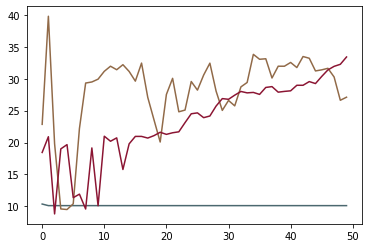

ROUND 49
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232465


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045321
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018579

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.347566
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.473434
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.532451

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.417073
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167029
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.319449

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.165568
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126663
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068388


Test set: Average loss for Cluster1 model: 6.56

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082864
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313710

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.480925
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.202442
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.869795

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 21.092829
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.621496
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.145781

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.441989
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.299688
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063018

Power Allocated= 2.605692174016901
CSI= 0.5

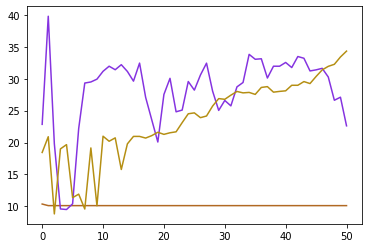

ROUND 50
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203857


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.375604
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310385

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195707
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048514
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194978

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.373847
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.393122
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.318697

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.420078
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140962
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111093

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071945
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.625904

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.531290
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.432038
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.328923

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.039141
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.470192
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.302746

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 11.298498
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044470
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104046

Power Allocated= 2.605692174016901
CSI= 0.

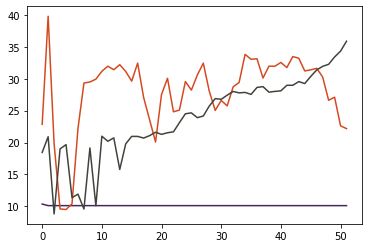

ROUND 51
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246834


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.373876
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.241799

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238626
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059324
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067887

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.402993
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.342933
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.408646

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.413911
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067776
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023568

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127179
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.406359

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.598465
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.555285
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313955

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.375893
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463876
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.074311

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.041512
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.428205
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050981

Power Allocated= 2.605692174016901
CSI= 0.5

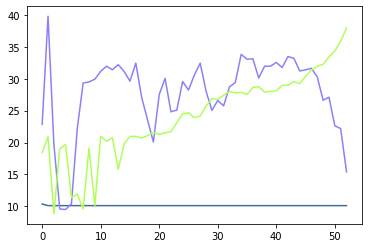

ROUND 52
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252193


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.384842
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132494

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.221948
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041414
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020170

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.416435
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165962
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.625219

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.141258
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277543
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.605204

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.189404
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362034
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.619954

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 24.813225
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.366941
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.579264

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.176749
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.385465
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104738

Power Allocated= 2.605692174016901
CSI= 0.5

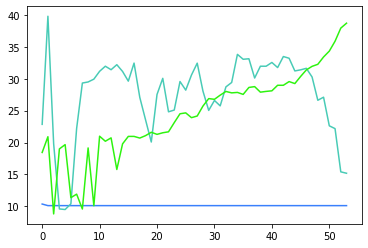

ROUND 53
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224588


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450010
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.227928

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226348
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103178
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068855

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.404387
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142616
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009554

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.132158
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244701
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306450

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.605478
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.477824
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.448836

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.357264
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.549425
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.028211

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.915307
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226724
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104687

Power Allocated= 2.605692174016901
CSI= 0.5

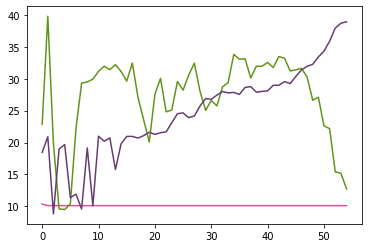

ROUND 54
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257627


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.452062
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.524024

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182289
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072309
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026224

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.365189
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.369753
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.140629

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.402242
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272539
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209897

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315618
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.610783

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.625946
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.385242
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224290

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 25.960993
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.525480
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.506433

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.789510
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367050
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004150

Power Allocated= 2.605692174016901
CSI= 0.5

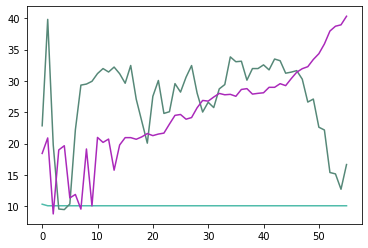

ROUND 55
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220914


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.512102
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017224

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228933
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107275
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.594808

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.362391
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.384479
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.369336

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.408760
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083061
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.423388

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058134
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118447

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.099854
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.386741
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.676641

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.864868
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.389786
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220012

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.698980
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276466
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226990

Power Allocated= 2.605692174016901
CSI= 0.5

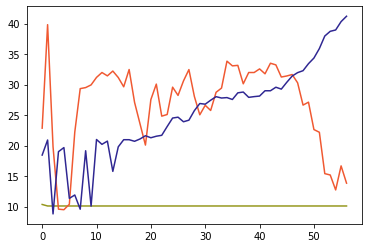

ROUND 56
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.242415


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.419995
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143889

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.199386
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053215
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036541

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.361938
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.918819
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.158305

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.399430
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.319357
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031220

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307324
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210768

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.069935
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.561373
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.451695

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.117804
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.394096
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.638213

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.446592
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227299
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202824

Power Allocated= 2.605692174016901
CSI= 0.5

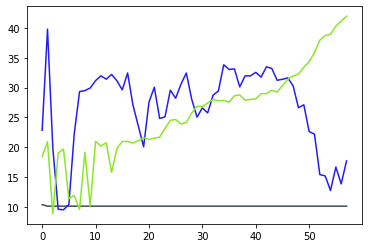

ROUND 57
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212690


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.311787
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.301087

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206112
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172211
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.506194

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.374377
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.285653
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.112597

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.408900
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105674
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184801

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.518019
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180854

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.237648
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.437359
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417875

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.594282
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.402104
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.707184

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.691463
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.568361
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.727524

Power Allocated= 2.605692174016901
CSI= 0.5

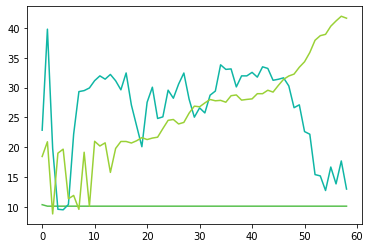

ROUND 58
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212058


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328129
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.794263

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238066
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060418
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034057

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.410669
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052846
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231362

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.157688
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278349
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.572390

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.626640
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.643279
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.083605

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.857920
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.763141
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.610137

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.010698
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210677
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237303

Power Allocated= 2.605692174016901
CSI= 0.5

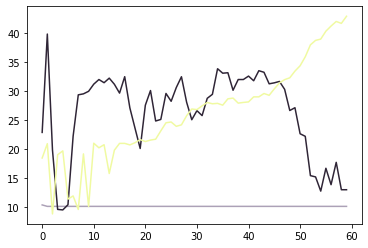

ROUND 59
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.185923


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303086
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207960

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.245387
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020847
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.399163

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.350903
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.348608
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.975399

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.406779
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051617
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001237

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233713
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175213

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.006119
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.470920
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.291745

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.812893
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.630626
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.364765

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.183549
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.353916
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.242839

Power Allocated= 2.605692174016901
CSI= 0.5

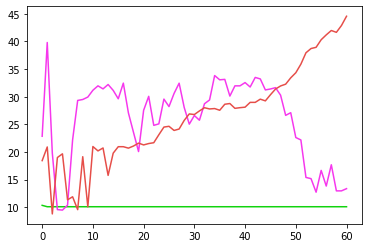

ROUND 60
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.236192


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.606570
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149945

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.189402
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044724
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092740

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.319517
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.175298
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.744748

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.402971
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107884
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181384

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061365
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.344890

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.940849
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.421742
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.514949

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.252884
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.546683
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.839562

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.807200
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242203
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246438

Power Allocated= 2.605692174016901
CSI= 0.5

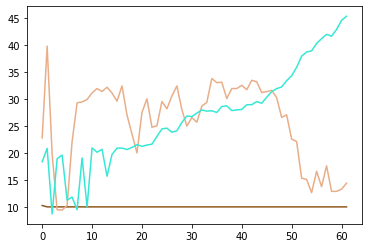

ROUND 61
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.205016


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309948
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104533

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212065
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068540
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013915

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.354880
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.138605
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.857214

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.402937
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099838
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001903

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109187
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.552191

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.429615
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.453033
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402425

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.149452
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.371463
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.205057

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.127159
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230367
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.290748

Power Allocated= 2.605692174016901
CSI= 0.5

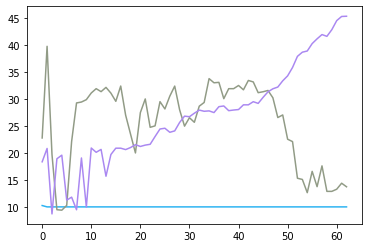

ROUND 62
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232836


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212866
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.253212

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194884
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234865
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037900

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.324741
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.254465
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.208767

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.392074
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100750
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.292210

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.395205
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.944836

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.252300
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.423249
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.446085

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.983431
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.578772
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.738083

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.974363
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155857
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018739

Power Allocated= 2.605692174016901
CSI= 0.5

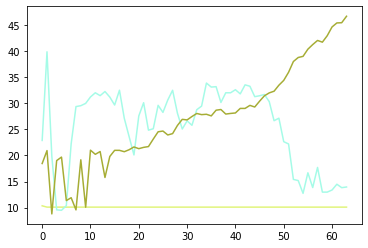

ROUND 63
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235346


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278829
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121232

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.158533
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.252899
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011470

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.387078
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091799
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289857

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.145642
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142113
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151541

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 49.799713
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.550716
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.898339

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.010040
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.592069
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.674280

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.557673
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120425
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064405

Power Allocated= 2.605692174016901
CSI= 0.5

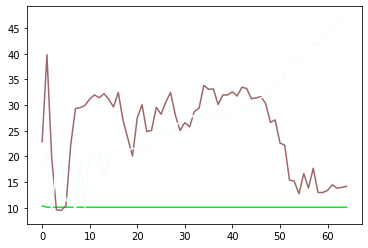

ROUND 64
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.199157


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152100
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018600

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182784
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010429
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001758

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.393845
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067302
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050425

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.148720
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176228
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149905

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.657179
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.430011
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.628842

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 25.792339
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.573355
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.604068

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.751203
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367312
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173808

Power Allocated= 2.605692174016901
CSI= 0.5

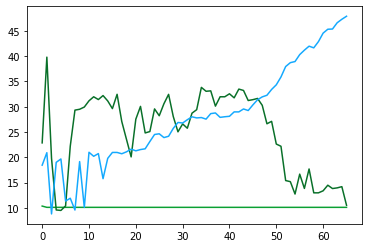

ROUND 65
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.186820


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113765
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121812

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.208026
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038208
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081748

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.387401
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088558
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155295

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.099070
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043788
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116334

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.299294
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.021405
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.799608

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.607597
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.658838
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.710508

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.758226
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254900
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174803

Power Allocated= 2.605692174016901
CSI= 0.5

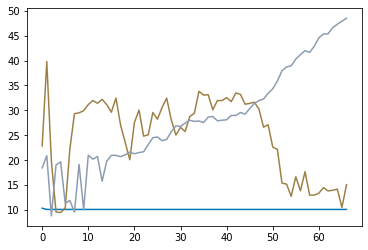

ROUND 66
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.214171


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242350
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036328

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.209230
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027392
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143312

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.327863
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.075861
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.984808

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.387814
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121337
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001597

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.300098
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.319747

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.154182
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.320650
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.776788

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.286076
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.706985
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.089723

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.117182
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096629
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.510813

Power Allocated= 2.605692174016901
CSI= 0.5

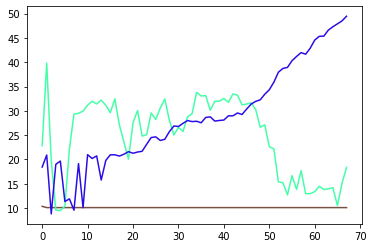

ROUND 67
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210661


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066210
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052008

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.171610
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059221
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024002

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.393043
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066631
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006683

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.125685
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.357332
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.186076

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.480286
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.856785
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.824052

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.550442
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.627369
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.421431

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.447494
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107011
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.296685

Power Allocated= 2.605692174016901
CSI= 0.5

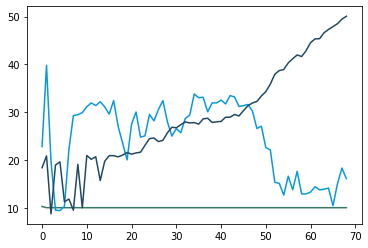

ROUND 68
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.183677


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159966
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262167

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.205211
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153113
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067663

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.386589
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027609
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072858

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.149983
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137461
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203841

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.964069
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.773893
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.212583

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.872274
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.787671
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.645571

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.838799
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091702
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.414222

Power Allocated= 2.605692174016901
CSI= 0.5

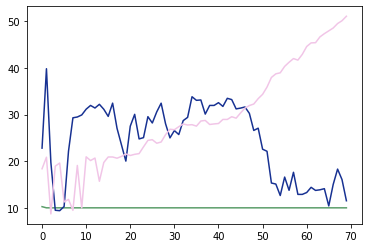

ROUND 69
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224533


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113310
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.546067

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.183039
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134704
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003641

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.311287
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077799
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.572468

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.375311
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083739
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014833

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.557906
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141668

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.596230
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.834562
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.841985

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.941071
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.245787
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.210763

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 10.365661
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330518
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.520499

Power Allocated= 2.605692174016901
CSI= 0.

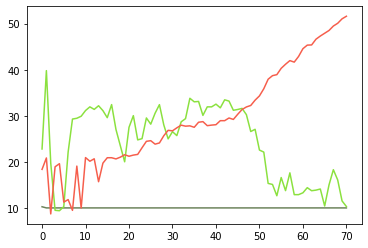

ROUND 70
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196009


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230385
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025855

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.179297
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043763
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069956

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.331121
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.880027
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.666709

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.390218
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148453
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255920

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244502
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.181512

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 49.020275
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.517270
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.576234

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.591484
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.400967
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.463673

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.482673
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248427
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.749797

Power Allocated= 2.605692174016901
CSI= 0.5

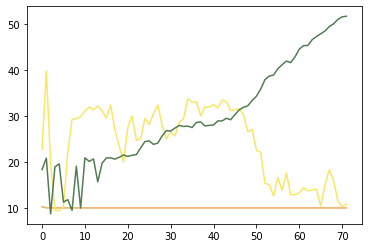

ROUND 71
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.154735


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029083
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022120

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.379035
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102791
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.293873

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.074553
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101798
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.886197


Test set: Average loss for Cluster1 model: 14.0593, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163708
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217671

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 53.998390
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.956514
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.927543

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 49.814026
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 3.357356
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.833115

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.556716
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222615
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.519524

Power Allocated= 2.605692174016901
CSI= 0.5

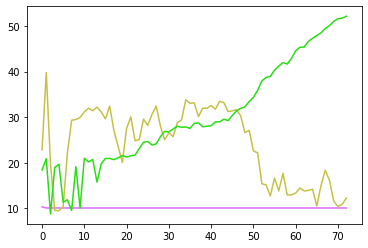

ROUND 72
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253572


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151259
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069853

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200370
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178010
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058863

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.356481
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.907033
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.518235

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.378444
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037803
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116612

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127952
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249884

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.196404
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.148664
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.819689

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.442307
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.033755
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.123279

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.328556
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246103
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.720749

Power Allocated= 2.605692174016901
CSI= 0.5

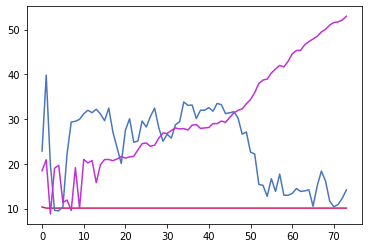

ROUND 73
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.208381


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120716
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047751

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.109169
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102287
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314466

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335731
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.611846
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.442668

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.374141
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126850
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000006

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020038
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099398

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 55.767056
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.812199
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.919465

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.161112
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.849476
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.385257

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.266135
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164250
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170399

Power Allocated= 2.605692174016901
CSI= 0.5

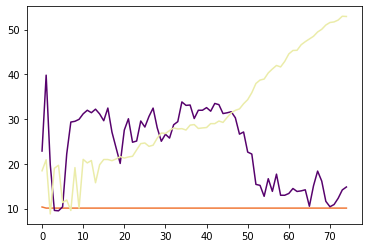

ROUND 74
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.146112


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059705
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.675042

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.379568
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.462705
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335095

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.137225
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153595
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044540


Test set: Average loss for Cluster1 model: 16.0237, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228256
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217565

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.869579
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.773100
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.974225

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.678028
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.752468
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.829583

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.492138
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275707
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.615968

Power Allocated= 2.605692174016901
CSI= 0.5

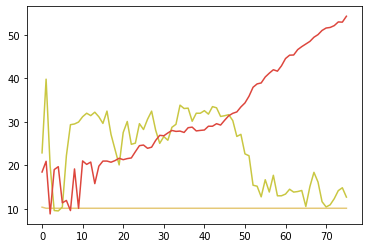

ROUND 75
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.162251


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067491
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294070

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.163284
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118991
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125232

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.374678
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227661
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147209

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.136230
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.386464
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.763535

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.362713
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.760341
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.979406

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.836166
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.111528
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 6.375887

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.921538
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.764704
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.524875

Power Allocated= 2.605692174016901
CSI= 0.5

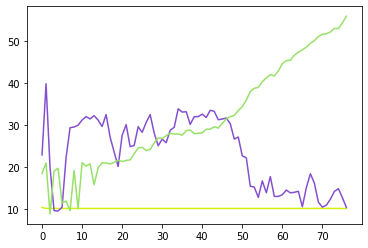

ROUND 76
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.229716


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215927
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.295888

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.142690
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.360756
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357434

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.345545
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.824004
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.266814

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.369608
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152794
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020537

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.324912
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.418722

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.609299
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.995406
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.063454

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.727081
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.400968
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.213275

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.875729
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179309
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.520940

Power Allocated= 2.605692174016901
CSI= 0.5

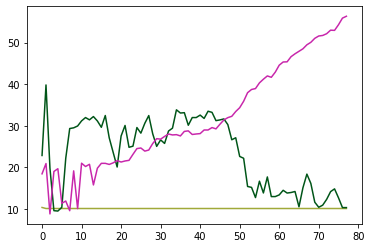

ROUND 77
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230856


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362101
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.902705

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.135748
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052689
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023784

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.342750
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.549204
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.760771

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.360375
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076950
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008099

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.740067
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.164345

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.780453
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.761722
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.254730

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.591885
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.042369
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.977134

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.245203
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120097
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.622327

Power Allocated= 2.605692174016901
CSI= 0.5

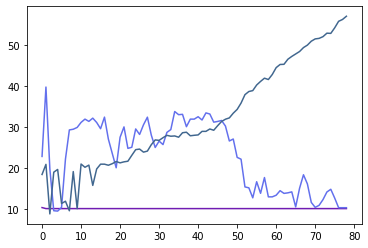

ROUND 78
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212045


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.321808
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000050

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.140598
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056125
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135663

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304249
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.558386
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239024

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.362989
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069480
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001078

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.524170
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076913

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 50.738491
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.912392
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.053996

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.880737
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.142842
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.183526

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.967784
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.358940
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.486722

Power Allocated= 2.605692174016901
CSI= 0.5

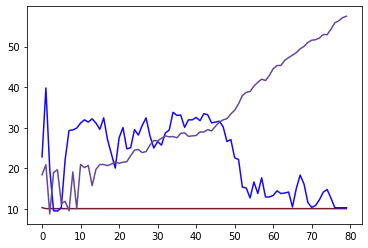

ROUND 79
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210119


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131615
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158896

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.143479
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060134
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000096

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294756
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.452187
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145209

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.383054
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037682
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094197

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224084
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.339654

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.168755
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.054246
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.022265

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.602509
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.975986
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.114037

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.130815
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088018
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.851798

Power Allocated= 2.605692174016901
CSI= 0.5

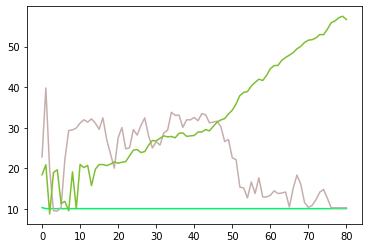

ROUND 80
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253749


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100253
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094311

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.095868
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075794
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.684819

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.320030
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.373935
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.354679

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.367011
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056335
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003013

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063526
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269542

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.850689
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.065132
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.072694

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.338104
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.016609
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.049862

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.098644
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.605989
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.168852

Power Allocated= 2.605692174016901
CSI= 0.5

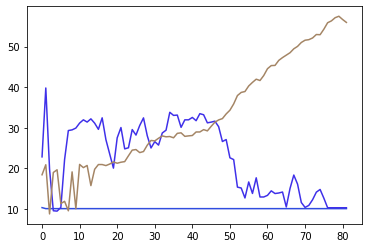

ROUND 81
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195374


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064029
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.561059

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.154725
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028839
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129076

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.359160
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088411
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116582

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.068886
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258776
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220850

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.503399
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.968097
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.116859

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.818676
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.075631
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.940466

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.056654
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223539
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.707248

Power Allocated= 2.605692174016901
CSI= 0.5

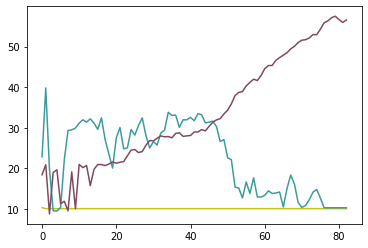

ROUND 82
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.192756


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199429
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.695414

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.124470
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257805
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058382

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314970
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.524679
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.472443

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.377077
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091174
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108993

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.365426
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087797

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.116085
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.953225
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.304260

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.329918
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.473609
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.047353

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.479771
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275026
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.320549

Power Allocated= 2.605692174016901
CSI= 0.5

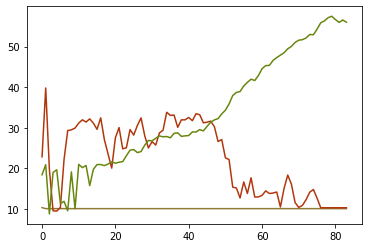

ROUND 83
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.245275


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212043
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107097

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.177487
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204173
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236044

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.359081
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153757
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050459

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.069755
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.419636
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151145

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 55.647415
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.766935
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.003076

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.710476
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.115875
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.076307

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.977515
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168096
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106232

Power Allocated= 2.605692174016901
CSI= 0.5

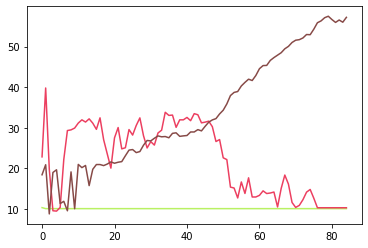

ROUND 84
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.167576


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166633
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113299

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.137450
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254732
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265385

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.359493
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.387503
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.560936

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.372553
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298151
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083997

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141640
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236415

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 51.288460
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.237666
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.044636

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.413918
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.082299
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.991423

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.640007
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148991
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159347

Power Allocated= 2.605692174016901
CSI= 0.5

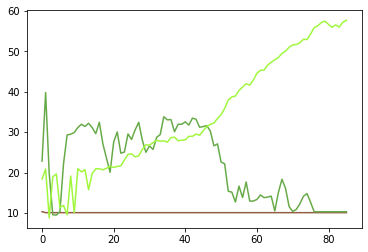

ROUND 85
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.236923


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048437
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033810

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176575
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286100
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053854

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.346367
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112680
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050483

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.098663
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.386136
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379692

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.149513
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.928082
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.089138

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.539219
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.057554
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.997287

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.949157
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026139
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139765

Power Allocated= 2.605692174016901
CSI= 0.5

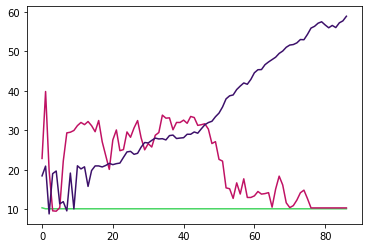

ROUND 86
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166940


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178262
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282086

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.173134
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158390
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036339

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.341642
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347008
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132125

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.048243
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266095
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.293307

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.997826
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.968570
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.076554

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.563251
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.978258
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.993511

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.255095
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120241
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203289

Power Allocated= 2.605692174016901
CSI= 0.5

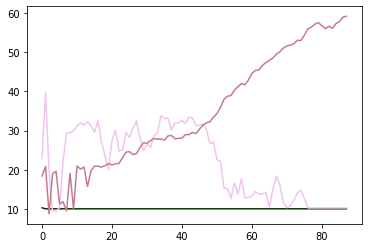

ROUND 87
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.159218


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176812
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.075544

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.105629
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120558
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076928

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.344316
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.287751
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.619382

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.061858
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068439
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.761979

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 59.700428
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.153165
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 4.934775

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.146175
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.062576
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.040636

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.498990
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.494630
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.356155

Power Allocated= 2.605692174016901
CSI= 0.5

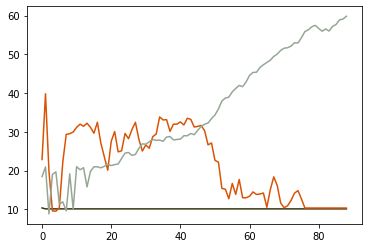

ROUND 88
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210120


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121984
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.621312

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.136582
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057007
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046325

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.343265
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079546
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.615608

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.101791
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131125
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.483115

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 48.349197
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.997546
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.977283

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.391273
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.154320
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.089734

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.108476
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.757158
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.045152

Power Allocated= 2.605692174016901
CSI= 0.5

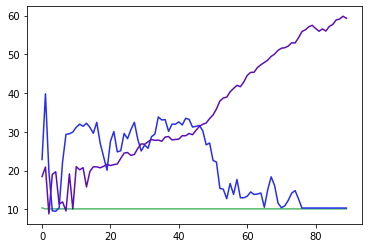

ROUND 89
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.236321


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.292841
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.539307

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.136934
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025821
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019230

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275918
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.513901
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.367922

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.352298
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083225
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148181

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082898
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330266

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.873989
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.085059
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.136578

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.951508
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.157307
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.973765

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.610052
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.021373
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.585625

Power Allocated= 2.605692174016901
CSI= 0.5

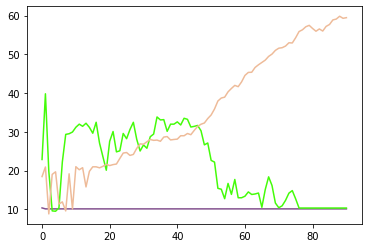

ROUND 90
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198497


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551281
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.601610

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.109607
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001515
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005427

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.313529
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.355309
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135747

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.344129
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056501
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276166

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225642
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286432

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 49.548622
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.078283
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.030332

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 50.294300
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.112512
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.022631

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.378418
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.294921
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311390

Power Allocated= 2.605692174016901
CSI= 0.5

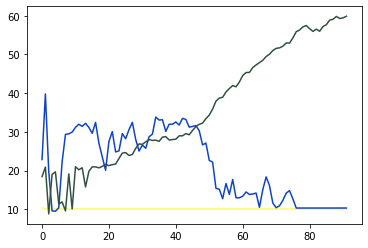

ROUND 91
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.097259


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051926
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289461

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.342948
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103339
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028709

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.076921
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110997
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330891


Test set: Average loss for Cluster1 model: 25.1814, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220870
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.505597

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 51.121933
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077058
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 17.032866

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.681957
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.135438
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.856037

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.368068
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.779192
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.034501

Power Allocated= 2.605692174016901
CSI= 0.

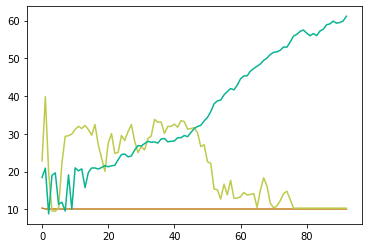

ROUND 92
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.149432


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053291
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.248008

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.090860
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042956
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031291

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.340813
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004304
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143563

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.084193
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241293
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125410

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 54.248920
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.156451
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.043658

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.487610
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.105472
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.183308

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.357374
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.466459
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 4.402758

Power Allocated= 2.605692174016901
CSI= 0.5

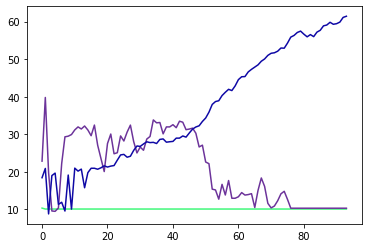

ROUND 93
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176998


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067049
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124927

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.189306
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029137
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.465874

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.337209
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367336
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112199

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.353525
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112914
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044775

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.535654
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.360811

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.993114
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.132573
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.129309

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.341625
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.140085
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.156996

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.830956
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.992382
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.883618

Power Allocated= 2.605692174016901
CSI= 0.5

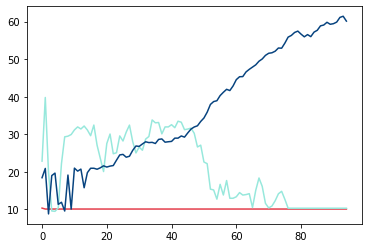

ROUND 94
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227596


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077835
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017008

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.091084
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056608
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272946

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299426
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.410766
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.311999

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.325732
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249293
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.386868

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.600293
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.109375

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.712257
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.035693
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.988636

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.844959
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.085793
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.049608

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.271922
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.950367
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.376418

Power Allocated= 2.605692174016901
CSI= 0.5

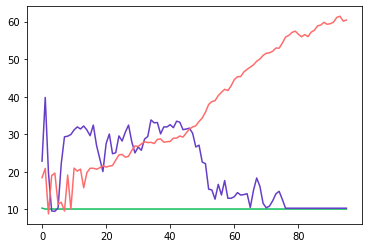

ROUND 95
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.106169


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024748
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190694

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312454
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.279111
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.736611

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.339110
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054827
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050129

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.035624
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058091
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.740166


Test set: Average loss for Cluster1 model: 42.4

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.586126
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.376528

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.678448
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.033125
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.048471

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.302940
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.093840
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.086399

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.784138
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.014593
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.170053

Power Allocated= 2.605692174016901
CSI= 0.5

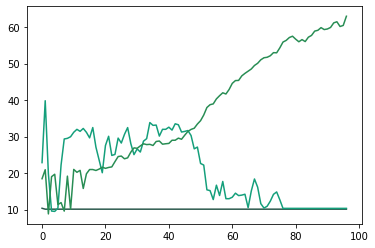

ROUND 96
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190389


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061678
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045416

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.144260
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056572
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197387

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289726
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280871
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377928

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.319143
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062484
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021225

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.596792
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.714592

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.226116
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.095764
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.081411

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.127016
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087630
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 15.981797

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.151663
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.068388
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.850718

Power Allocated= 2.605692174016901
CSI= 0.

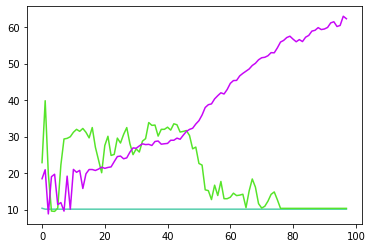

ROUND 97
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.177363


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077939
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349237

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196271
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040711
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000192

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.325969
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265767
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.589195

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.340905
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441946
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265640

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.373228
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.401000

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.293970
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.936065
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.049228

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 24.191299
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087802
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.091917

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.337426
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.810054
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.631484

Power Allocated= 2.605692174016901
CSI= 0.5

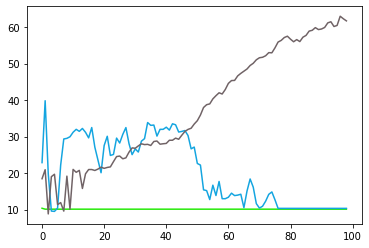

ROUND 98
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.152948


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091590
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.206437

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.107304
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031455
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.268349

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293638
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264627
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484444

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.348101
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073578
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023007

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227083
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.424136

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.818119
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.244517
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.975387

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.168480
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.111365
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.124301

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.208261
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.848332
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.696636

Power Allocated= 2.605692174016901
CSI= 0.5

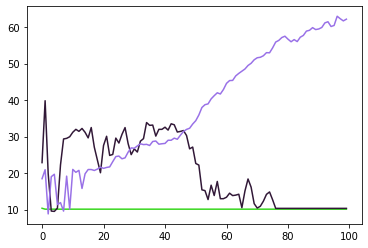

ROUND 99
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.172124


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059892
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075875

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.057909
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019959
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120432

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298700
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.358047
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.506069

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335556
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075496
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022604

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.672599
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.647699

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.206196
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.581672
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.030245

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.276123
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.115922
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.058048

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.838829
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.847852
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.747488

Power Allocated= 2.605692174016901
CSI= 0.5

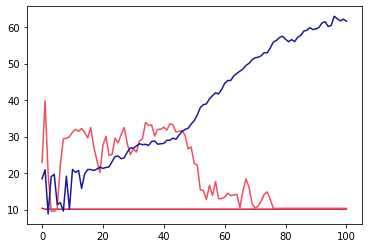

ROUND 100
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.154270


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156392
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017641

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.098978
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019675
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128229

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298494
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183700
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.962568

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.350201
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090693
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102753

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.448211
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.573238

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.127930
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.068520
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.059619

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.512459
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.123143
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.088604

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.619392
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.148828
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.949783

Power Allocated= 2.605692174016901
CSI= 0.5

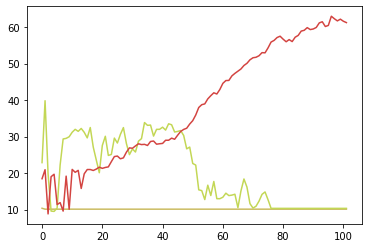

ROUND 101
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.105787


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103902
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250477

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.333504
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107021
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054697

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.337083
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011558
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.791996

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.057580
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201387
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182866


Test set: Average loss for Cluster1 model: 46.9

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212557
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.591695

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.443512
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.126076
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.050086

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.072670
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.131809
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.119812

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.481624
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.054572
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.850381

Power Allocated= 2.605692174016901
CSI= 0.5

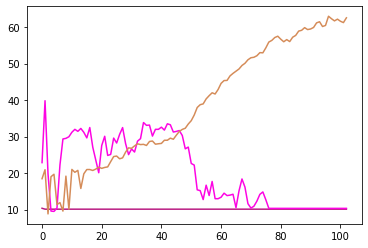

ROUND 102
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.169271


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213886
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210031

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.148441
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054504
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019595

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.321293
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239854
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278822

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.336960
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066574
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184787

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214480
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.479005

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.217155
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.049437
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.044625

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.712654
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.091733
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.178200

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.739585
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.411988
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.822346

Power Allocated= 2.605692174016901
CSI= 0.5

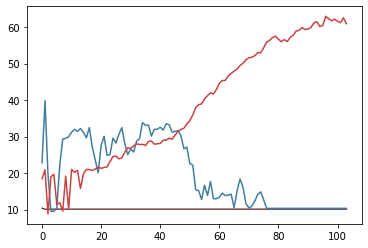

ROUND 103
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194929


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146162
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018138

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.044727
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051431
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.504110

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303023
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142288
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250262

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.340078
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117560
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247828

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.321928
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347036

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.694675
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.062541
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.110884

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.257278
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.119126
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.163338

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.771061
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.591341
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.521565

Power Allocated= 2.605692174016901
CSI= 0.5

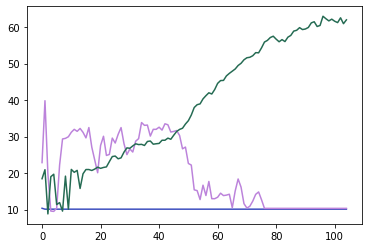

ROUND 104
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.173807


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201460
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109529

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.072519
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062066
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.578938

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300347
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165866
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177145

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.328825
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020706
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230495

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.930174
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.546229

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.617645
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.081562
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.012823

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.628815
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.120624
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.018914

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.213571
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.421491
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.625499

Power Allocated= 2.605692174016901
CSI= 0.5

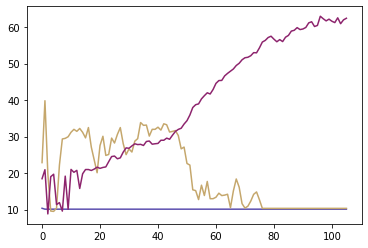

ROUND 105
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.142883


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027801
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000006

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.151329
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127874
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.483205

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.339702
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069385
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402669

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.071046
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265045
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.532135

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.735638
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.096109
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.082033

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.333202
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.081885
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.095363

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.906634
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.493345
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.151856

Power Allocated= 2.605692174016901
CSI= 0.5

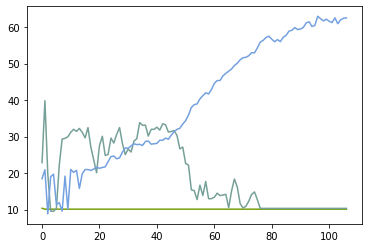

ROUND 106
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231461


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038493
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000178

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.114168
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012606
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012145

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335412
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014679
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038493

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.009090
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.935461
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.711522

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.593361
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.105031
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.131974

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.551632
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.062995
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.018005

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.413554
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.699639
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.535895

Power Allocated= 2.605692174016901
CSI= 0.5

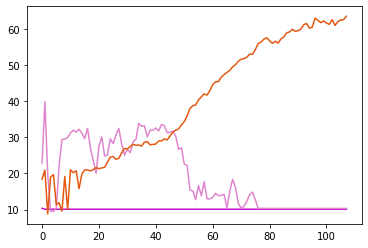

ROUND 107
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.139174


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028234
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144763

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.103033
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043003
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001221

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.318594
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148683
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074968

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.332738
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046587
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167274

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345593
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.733381

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.802246
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.047173
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.062065

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.391376
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.052140
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.041855

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.919208
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.498354
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.619593

Power Allocated= 2.605692174016901
CSI= 0.5

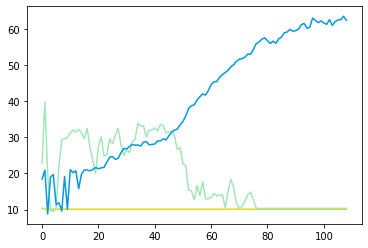

ROUND 108
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.215144


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148485
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288452

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.032936
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003556
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.563693

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314136
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174265
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116271

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.329504
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066828
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097368

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.643643
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.755241

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.959274
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.030278
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.066369

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.357849
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.097496
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.108709

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.295591
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233416
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.517898

Power Allocated= 2.605692174016901
CSI= 0.5

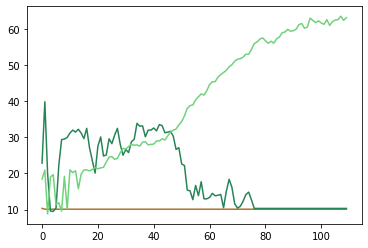

ROUND 109
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.219604


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.287762
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035489

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.096659
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.462025
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004044

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314001
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120885
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.482781

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.357120
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138441
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169444

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.471666
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.718468

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.926849
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.103357
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.062479

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.990606
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.097543
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.083762

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247397
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.662053
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283200

Power Allocated= 2.605692174016901
CSI= 0.5

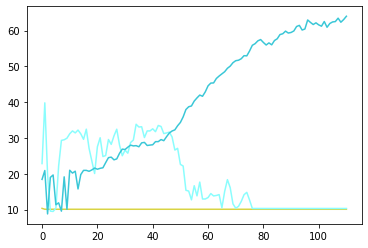

ROUND 110
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.172272


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281000
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.045086
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021052
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.741717

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.342396
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195716
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142778

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.337134
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030914
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202495

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.567837
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.570976

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.928520
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.096951
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.073949

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.855389
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071374
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.872787

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.310741
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330382
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.056633

Power Allocated= 2.605692174016901
CSI= 0.5

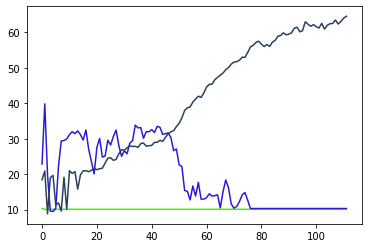

ROUND 111
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.151719


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057496
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145808

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.061270
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168537
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071700

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.311819
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.338083
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128457

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.320863
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104088
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015315

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.672698
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.538861

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.621403
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.098206
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.095868

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.475075
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079229
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.058246

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.164648
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.337274
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.565606

Power Allocated= 2.605692174016901
CSI= 0.5

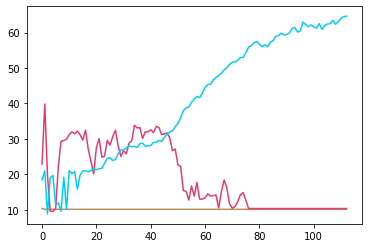

ROUND 112
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.144295


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129804
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.350822

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.083725
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024058
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093138

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.360095
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203552
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072202

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.334677
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002242
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.305896

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.184071
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.635057

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.030060
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.118831
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.061315

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.904892
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.100548
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.978917

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.601018
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244892
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.749327

Power Allocated= 2.605692174016901
CSI= 0.5

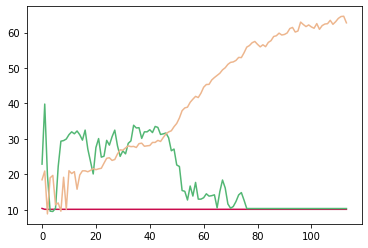

ROUND 113
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.175918


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050091
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000009

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.111349
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022502
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007387

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335710
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107815
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097805

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.075740
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.517885
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289624

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 51.063919
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.092222
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.999324

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.180004
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.129088
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.023590

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.600749
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.365292
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.163862

Power Allocated= 2.605692174016901
CSI= 0.5

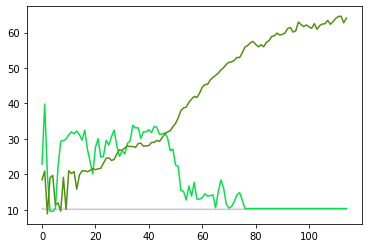

ROUND 114
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.156816


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170596
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.407102

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.103140
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174212
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011986

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.323421
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010134
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037215

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.004847
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.283635
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.489563

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.353516
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.063503
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.058905

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.923717
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.110442
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.157216

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.689631
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367488
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.487158

Power Allocated= 2.605692174016901
CSI= 0.5

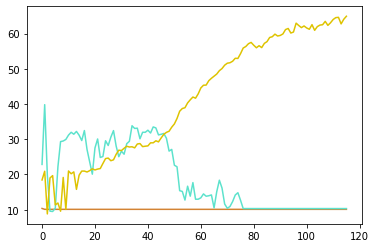

ROUND 115
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.118991


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012867
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023872

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.333426
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.229949
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094928

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.008245
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154761
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053306


Test set: Average loss for Cluster1 model: 41.9060, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450411
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.531551

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.848793
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059310
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.939997

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.904194
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.144354
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.949622

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.795410
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.386475
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.465969

Power Allocated= 2.605692174016901
CSI= 0.5

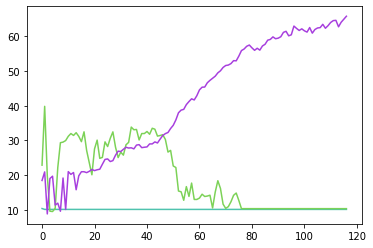

ROUND 116
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.158421


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219778
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191553

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.086912
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031781
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.311813

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.325007
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043095
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.087674

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.028262
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247246
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321383

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.573219
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.084156
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.060924

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.418045
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.070169
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.948536

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.247449
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.389206
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379250

Power Allocated= 2.605692174016901
CSI= 0.5

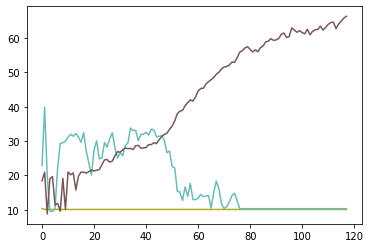

ROUND 117
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.173903


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149499
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.228456

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.028029
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.377437
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.095541

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288409
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101967
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221674

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.311613
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048109
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094552

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.416826
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.678351

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.585781
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.197609
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.088836

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.178780
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.108656
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.108523

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.628311
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.324939
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.497041

Power Allocated= 2.605692174016901
CSI= 0.5

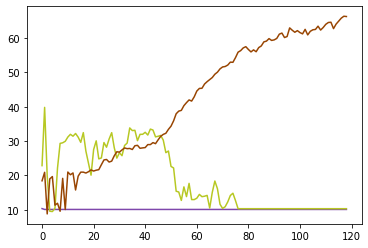

ROUND 118
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.165638


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328353
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239755

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.111980
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240574
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079454

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271960
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127017
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404799

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.340706
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044460
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084597

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.713990
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.786996

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.299576
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080582
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.121597

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.348169
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.037774
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.209312

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.963410
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307844
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480489

Power Allocated= 2.605692174016901
CSI= 0.5

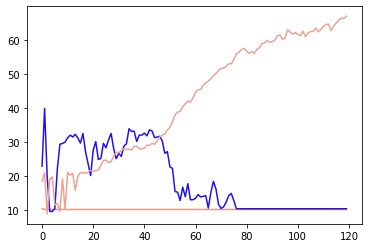

ROUND 119
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.113936


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104941
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.690630

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.116806
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055209
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283628

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.333175
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096250
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119640

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.994552
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.728773
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.958594

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.459200
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.088678
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.141458

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.804436
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.138739
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.061457

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.419297
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.348944
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222563

Power Allocated= 2.605692174016901
CSI= 0.5

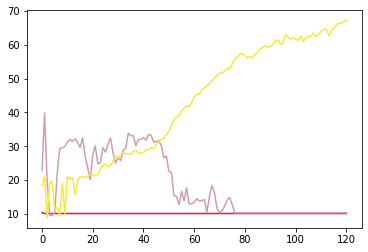

ROUND 120
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.210150


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307456
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073111

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.071596
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117707
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161220

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289821
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266437
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024126

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.324325
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085860
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.018404
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.910606

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.067131
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.073086
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.019591

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.273899
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.072560
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.275442

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.541564
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.353813
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.358421

Power Allocated= 2.605692174016901
CSI= 0.5

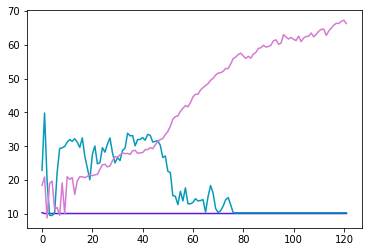

ROUND 121
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.122941


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.339287
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163897

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.103006
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.548795
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084361

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.323982
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051438
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.558908

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.050544
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.696821
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.769807

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.603188
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.069037
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.174197

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.229759
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079866
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.158823

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.836289
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.706063
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177627

Power Allocated= 2.605692174016901
CSI= 0.5

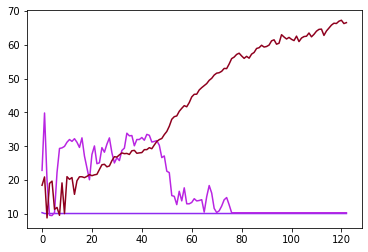

ROUND 122
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.149817


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104229
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336819

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.134126
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155930
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.745054

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.333005
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.301949
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247970

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.016344
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.091188
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.002185

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.302242
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080235
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.098007

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.221420
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.057813
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.962462

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.115781
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249476
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.560552

Power Allocated= 2.605692174016901
CSI= 0.5

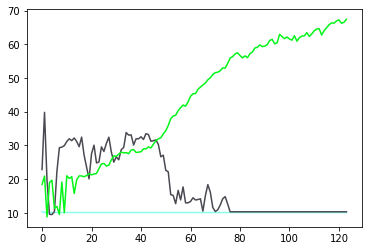

ROUND 123
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220150


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033049
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006658

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.112796
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074518
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036621

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304307
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130428
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.536297

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.313899
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175278
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189353

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.733013
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.410041

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.353142
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071422
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.096419

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.833952
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.098457
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.074086

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.713661
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180466
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.966698

Power Allocated= 2.605692174016901
CSI= 0.5

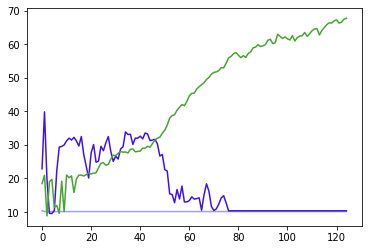

ROUND 124
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.135794


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013359
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154029

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.064936
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082348
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083974

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307018
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072698
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034114

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.088573
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.790964
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484837

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 53.210155
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080445
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.106257

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 21.631405
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.095469
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.138697

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.986157
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.387198
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389310

Power Allocated= 2.605692174016901
CSI= 0.5

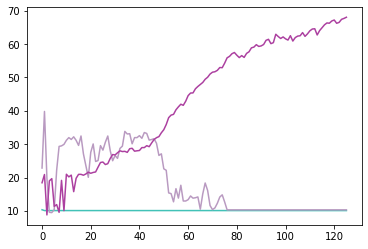

ROUND 125
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.155759


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092381
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.517739

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.058710
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187398
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053738

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276176
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067934
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000500

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.317866
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072618
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066565

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.684717
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.963096

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.405373
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.074150
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.065611

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.850491
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.085585
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.189929

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.129663
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186026
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.387970

Power Allocated= 2.605692174016901
CSI= 0.5

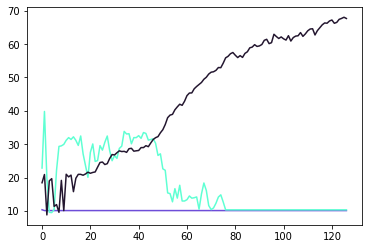

ROUND 126
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.152143


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008042
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003951

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.027329
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021601
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053677

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280046
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.320078
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.315656

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306851
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.744851
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.259773

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272445
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.318302

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.795895
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.097212
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.176269

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.739983
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.073401
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.117402

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274216
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174046
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214567

Power Allocated= 2.605692174016901
CSI= 0.5

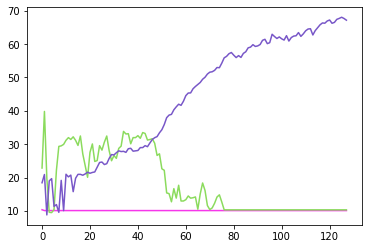

ROUND 127
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.065638


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073311
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221901

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263903
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185790
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114195

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.318671
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.336942
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216179

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.959854
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067081
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.445993


Test set: Average loss for Cluster1 model: 99.3

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.166615
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.924081

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.707901
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087427
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.035454

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.727306
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077572
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.170489

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.907319
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.445704
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.224510

Power Allocated= 2.605692174016901
CSI= 0.5

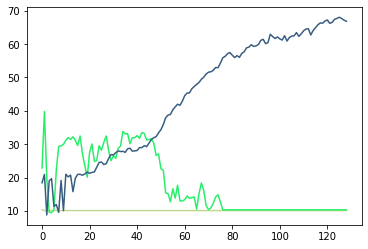

ROUND 128
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.047781


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002336
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274209
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106541
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058643

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.334719
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.430103
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085738

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.998778
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.764391
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020708


Test set: Average loss for Cluster1 model: 104.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347737
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.586746

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.586983
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.042078
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.090641

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.285801
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.052611
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.069965

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.488678
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400526
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.596140

Power Allocated= 2.605692174016901
CSI= 0.5

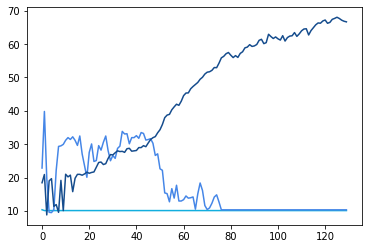

ROUND 129
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.140453


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174607
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038394

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.069654
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087151
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032453

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.323001
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228061
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230312

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.970247
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.652858
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.420085

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.777248
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079414
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.122900

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 50.158318
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.337564
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.176596

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.559604
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.419878
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.384578

Power Allocated= 2.605692174016901
CSI= 0.5

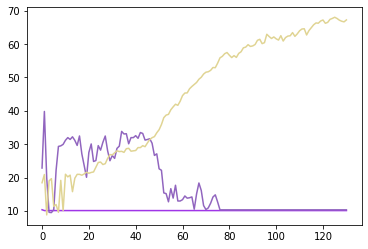

ROUND 130
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.174510


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052005
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088967

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.049430
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020688
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085612

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.339330
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.391748
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015512

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.065636
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.460521
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.664560

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 48.391968
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.042884
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.080264

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.377869
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.104305
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.112296

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.377122
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.689027
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.684386

Power Allocated= 2.605692174016901
CSI= 0.5

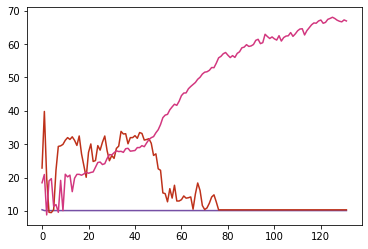

ROUND 131
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.151934


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120541
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172195

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.079127
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025641
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031785

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304417
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212008
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.300254

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.340860
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091900
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102309

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.717907
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.046755

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 49.115479
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.056990
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.032790

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.397507
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.052785
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.046863

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.451972
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.447372
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.993035

Power Allocated= 2.605692174016901
CSI= 0.5

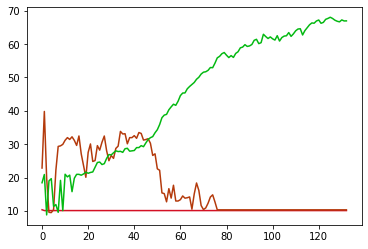

ROUND 132
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.071733


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020205
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.336382
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115044
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.093475
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076703
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114394


Test set: Average loss for Cluster1 model: 49.8979, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 3.172668
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.650788

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.559925
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.062730
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.085597

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 30.993673
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.076253
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.154361

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.387049
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.606079
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.039160

Power Allocated= 2.605692174016901
CSI= 0.5

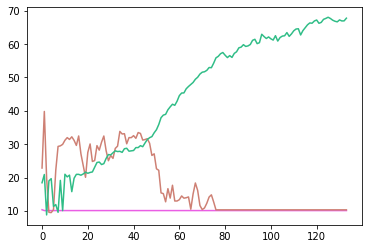

ROUND 133
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.208791


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082561
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.969410

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.072529
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045592
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002734

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.283917
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187342
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016082

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.962878
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.594355
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.956717

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.804367
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080134
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.979331

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.326847
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059813
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.227573

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.483989
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.768229
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.717295

Power Allocated= 2.605692174016901
CSI= 0.5

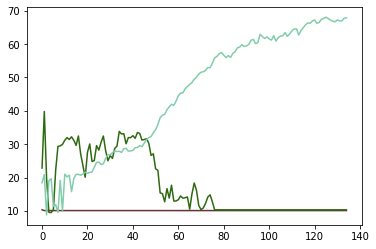

ROUND 134
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.121594


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276192
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.656308

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.091851
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036313
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120043

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286803
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165512
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182321

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.323736
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030566
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.624084

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.716026
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.165702

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 57.320629
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077581
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.120736

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.372555
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.058818
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.036092

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.070857
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.576027
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.702981

Power Allocated= 2.605692174016901
CSI= 0.5

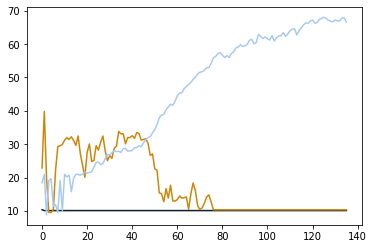

ROUND 135
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.012287


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034228
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015878

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314610
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106457
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158566

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312709
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033049
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015052

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.966746
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221941
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.767543


Test set: Average loss for Cluster1 model: 105.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.341282
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.665600

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.294338
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.053399
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.164616

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.670429
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.068851
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.216378

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.340690
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.685897
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.877100

Power Allocated= 2.605692174016901
CSI= 0.5

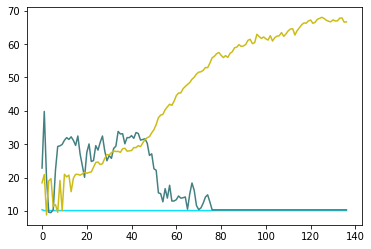

ROUND 136
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.180345


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.987579
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.906449

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.018915
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027007
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013130

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297301
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085448
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069020

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.318624
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010286
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053267

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.701053
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.086164

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.792919
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.078007
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.118608

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 49.325897
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.061485
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.066136

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.601421
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 3.255876
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.894967

Power Allocated= 2.605692174016901
CSI= 0.5

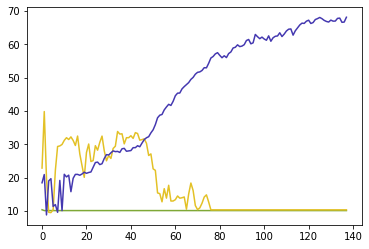

ROUND 137
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.110267


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.332446
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276940

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.030975
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068279
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024078

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228493
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.396609
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023138

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295730
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018315
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.526150

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325931
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.951303

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 48.294106
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.054605
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.132604

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 50.667171
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.086519
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.210782

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.269568
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.562779
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.701236

Power Allocated= 2.605692174016901
CSI= 0.5

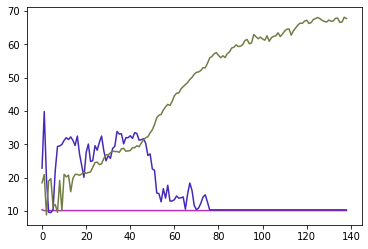

ROUND 138
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.064526


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117613
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148631

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.045052
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043428
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308511
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108974
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211879

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.968530
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.234412
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.571875

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.084320
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.060375
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.980556

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.017296
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.078840
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.054221

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.157121
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.541111
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.752569

Power Allocated= 2.605692174016901
CSI= 0.5

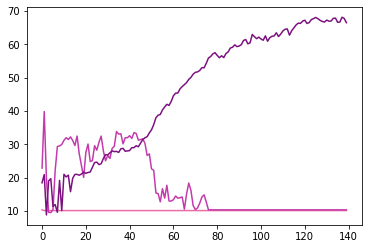

ROUND 139
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.115569


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193434
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.450233

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.034873
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251183
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.791915

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294339
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121179
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080135

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.316992
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089501
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013587

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.444063
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.223230

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.492863
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.045373
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.157914

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.869209
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.108359
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.161216

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.395121
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.596321
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.842114

Power Allocated= 2.605692174016901
CSI= 0.5

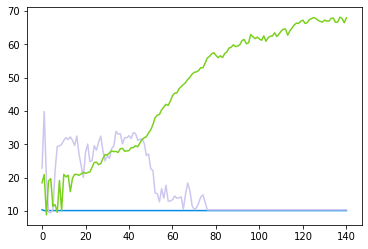

ROUND 140
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.131921


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082691
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.329984

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.038238
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233047
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120951

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239336
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177867
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.730298

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293209
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209540
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032038

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.985498
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953681

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.732576
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.085485
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.976177

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.537003
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.049012
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.028997

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.077934
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.695968
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.854639

Power Allocated= 2.605692174016901
CSI= 0.5

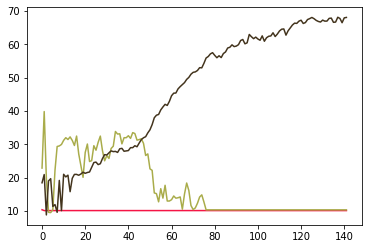

ROUND 141
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.130944


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159246
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010509

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.025231
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049209
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080902

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.331104
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164831
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014587

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.972464
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.923508
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.943389

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.967937
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079117
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.978758

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.012226
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059434
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.104325

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.634805
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.511043
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.737756

Power Allocated= 2.605692174016901
CSI= 0.5

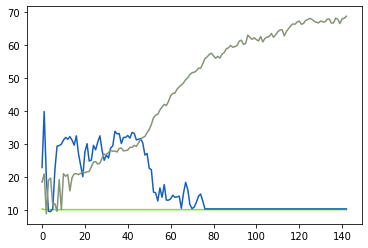

ROUND 142
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.107430


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189772
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.497177

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.083063
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135273
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.147478

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.283382
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260227
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231303

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.953116
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.058195
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.966577

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.189735
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.062587
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.028306

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.561260
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080567
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.032230

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.358439
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 3.881263
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.553453

Power Allocated= 2.605692174016901
CSI= 0.5

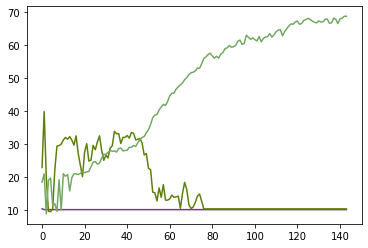

ROUND 143
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.096012


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119188
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011307

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.987589
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.252121
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148312

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290722
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.378712
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.432764

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.965677
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.831395
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.792400

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.996857
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.076363
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.141630

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.159172
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.067596
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.329049

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.530423
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.690993
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.796722

Power Allocated= 2.605692174016901
CSI= 0.5

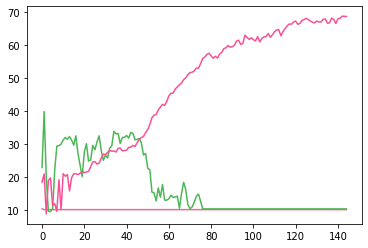

ROUND 144
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.109830


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063827
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143653

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.023319
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000227
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.752764

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196702
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132858
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417933

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.316176
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121028
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158084

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.679526
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.727555

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 50.618317
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.089605
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.059807

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.474499
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.058928
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.198807

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.923073
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.562454
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953464

Power Allocated= 2.605692174016901
CSI= 0.5

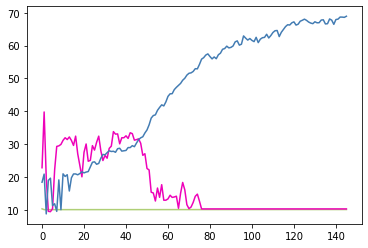

ROUND 145
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.100163


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089748
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143428

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.051274
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233430
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078282

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303440
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185884
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013197

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.008845
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.603174
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.580236

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 55.157875
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.064217
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038421

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.558113
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.092743
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.906752

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.749618
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.829239
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953606

Power Allocated= 2.605692174016901
CSI= 0.5

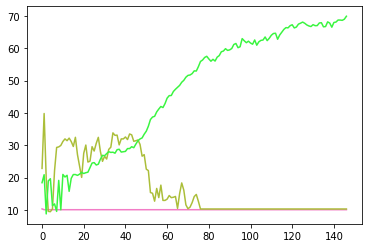

ROUND 146
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160385


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073781
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.473519

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.996883
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076661
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075350

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264683
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041310
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374989

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.316780
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129251
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040920

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414379
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.647406

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.568047
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.092411
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.065298

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.160103
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.081032
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.222000

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.051811
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.668587
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.869282

Power Allocated= 2.605692174016901
CSI= 0.5

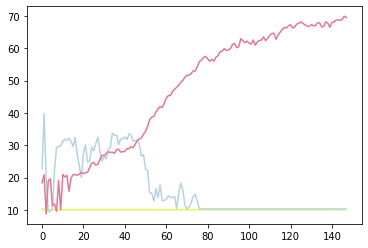

ROUND 147
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.080914


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180218
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051197

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.059936
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228688
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129483

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220989
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136393
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.136100

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309900
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.404253
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056161

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.686495
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.773830

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.908943
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077681
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.141359

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.016125
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.110054
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.272789

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 7.387700
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.980821
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 5.376088

Power Allocated= 2.605692174016901
CSI= 0.5

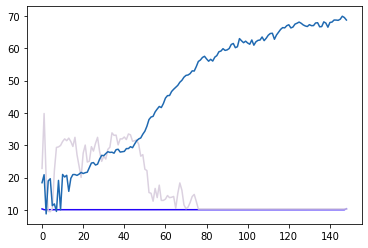

ROUND 148
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.066877


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231818
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006951

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.019354
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.290851
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173388

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297006
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153258
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151046

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293658
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164514
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070473

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392942
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.522948

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.013622
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.049920
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.139387

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.626617
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.029018
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.201603

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.036915
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.899373
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.984386

Power Allocated= 2.605692174016901
CSI= 0.5

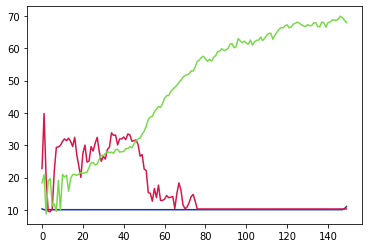

ROUND 149
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181847


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226258
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404094

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.996624
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.420178
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.596636

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314904
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130545
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.045657

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.988627
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.575222
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.642853

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.617622
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.064470
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.080883

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.438961
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.093620
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.074894

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827843
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.710822
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.045459

Power Allocated= 2.605692174016901
CSI= 0.5

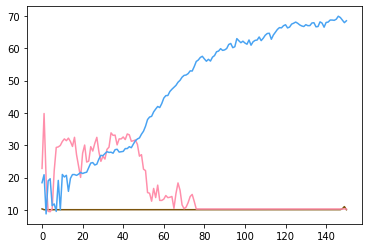

ROUND 150
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.049937


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.290257
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321781

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275185
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.250538
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.254792

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295916
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098727
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087908

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.997198
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133530
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.010020


Test set: Average loss for Cluster1 model: 58.6

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.777214
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.653206

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.535809
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077721
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.054253

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.215889
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.083708
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.167305

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.713459
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.333132
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.840231

Power Allocated= 2.605692174016901
CSI= 0.5

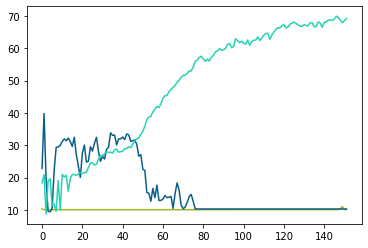

ROUND 151
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.126734


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171343
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159354

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.045595
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130549
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108674

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276564
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074439
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167674

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291457
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067299
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040874

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.791375
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.844162

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.412910
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.058654
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.023329

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.554226
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.082898
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.416217

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.389618
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.364195
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.806081

Power Allocated= 2.605692174016901
CSI= 0.5

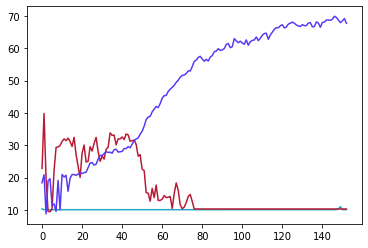

ROUND 152
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160350


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127396
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.938020

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.014888
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134063
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.412325

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239404
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.519392
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.546337

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.321842
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052701
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.387773

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.636081
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.849794

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.852562
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.060617
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.081834

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.748268
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.099351
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.016563

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.513229
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.630182
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.909086

Power Allocated= 2.605692174016901
CSI= 0.5

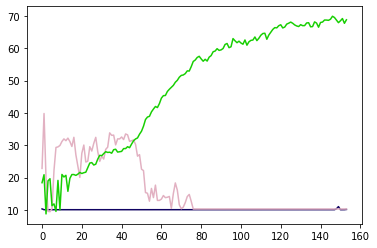

ROUND 153
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.150276


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048857
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004212

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.011230
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134979
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035664

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.322612
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102251
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193998

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.949518
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.505182
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.686598

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.735531
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.062877
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.062262

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.141308
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 43427.875000
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.062103

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.322439
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.449127
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.680080

Power Allocated= 2.605692174016901
CSI=

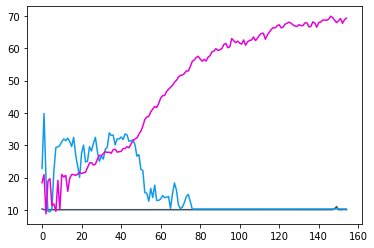

ROUND 154
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.144482


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065860
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068751

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.975209
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144400
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086172

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.283338
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053388
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029909

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.967298
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.377218
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.642809

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.801823
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071890
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.050211

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.204826
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.042943
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.448855

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.849419
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405867
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.617374

Power Allocated= 2.605692174016901
CSI= 0.5

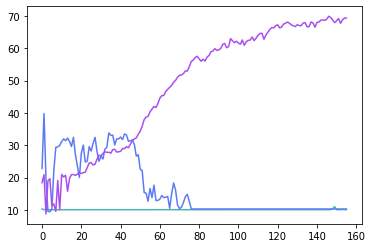

ROUND 155
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.155198


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073505
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008057

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.062037
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086197
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018639

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278126
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097238
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162763

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305943
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039501
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349796

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.652916
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.918622

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.453972
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.083705
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.022761

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 23.981512
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.029697
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.009185

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.845316
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.632453
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306195

Power Allocated= 2.605692174016901
CSI= 0.5

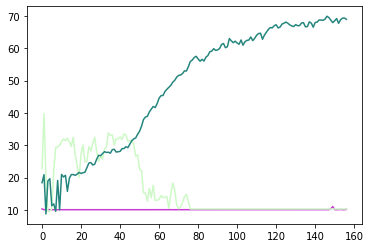

ROUND 156
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.075771


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.387400
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.506446

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.050398
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047529
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096039

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299658
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077742
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.976021

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277493
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195024
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005642

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.778918
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.880757

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.624678
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.043283
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.058632

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.092133
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.103485
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.188544

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.190228
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.623037
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.850304

Power Allocated= 2.605692174016901
CSI= 0.5

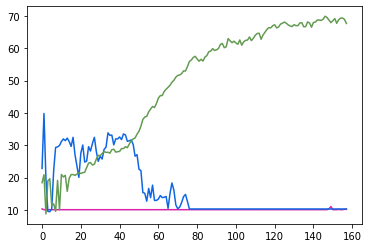

ROUND 157
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.116912


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166000
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203113

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.055031
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046047
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082423

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263561
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362339
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.456919

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299621
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335224
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109027

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.013674
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.812162

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.785933
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.032361
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.032149

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.136063
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.697067
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.304034

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.554336
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.682307
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 4.088854

Power Allocated= 2.605692174016901
CSI= 0.5

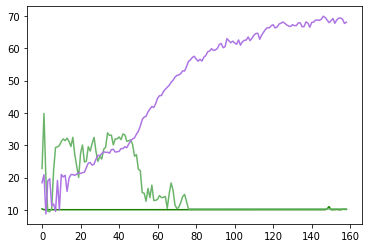

ROUND 158
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.162275


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174812
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094060

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.016276
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000102
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081269

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266667
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400647
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.447484

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291337
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127116
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.394758

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.780697
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.903704

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 54.312603
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.084800
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.162074

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.621185
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080787
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.077272

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.946872
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.547809
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.796276

Power Allocated= 2.605692174016901
CSI= 0.5

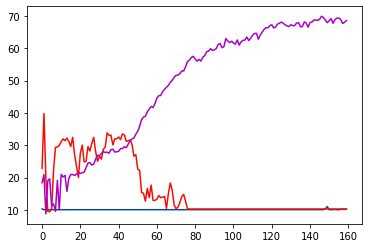

ROUND 159
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.097031


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083855
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118362

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.985483
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463730
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163497

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287005
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120804
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.615997

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298017
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103392
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148202

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.768852
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.839046

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.107006
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071102
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.010919

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.586170
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.109100
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.172502

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.849053
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.661997
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.016274

Power Allocated= 2.605692174016901
CSI= 0.5

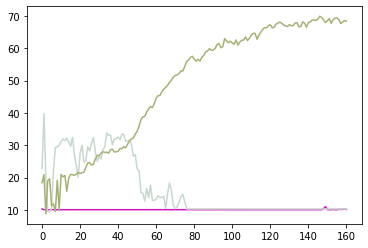

ROUND 160
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160238


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210209
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106879

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.995515
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154401
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069662

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269812
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088432
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078173

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.958262
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.840877
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.766013

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.517513
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 37.069431
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.023849

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.779400
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077815
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.176534

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.256638
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.844522
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038004

Power Allocated= 2.605692174016901
CSI= 0.

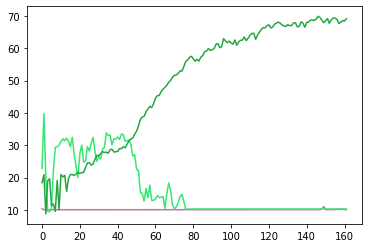

ROUND 161
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.082419


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041251
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.750620

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.061997
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041948
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050271

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262312
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084766
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207151

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278055
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.111810
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089537

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.462817
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.013262

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.110817
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079273
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.165915

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.036133
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071773
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.940466

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.438692
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.477183
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.863988

Power Allocated= 2.605692174016901
CSI= 0.5

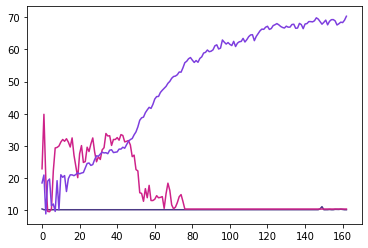

ROUND 162
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.143190


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036310
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004228

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.036117
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074423
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015093

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.273431
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048980
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.284909

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296890
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162966
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055246

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.451014
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.760480

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.329483
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059591
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.120589

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.800266
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.100956
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.188391

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.789881
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.928103
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.158432

Power Allocated= 2.605692174016901
CSI= 0.5

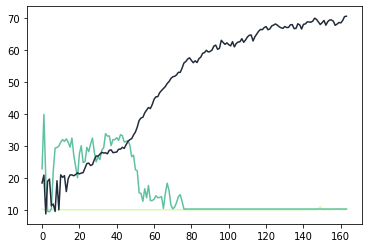

ROUND 163
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.177372


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001395
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000238

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.005278
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207962
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.223345

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275114
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122196
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126206

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.954622
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.422939
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953484

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 55.945213
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.045534
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.031425

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.624760
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.044257
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.174859

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.058447
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.953946
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.036335

Power Allocated= 2.605692174016901
CSI= 0.5

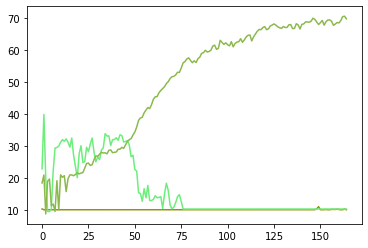

ROUND 164
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.084747


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.288174
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073198

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.939619
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463737
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.257519

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277211
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031052
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115246

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.944285
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.608902
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.111973

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.747433
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.075279
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.113973

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.888706
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.089126
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.095423

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 9.613750
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.947666
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.986624

Power Allocated= 2.605692174016901
CSI= 0.5

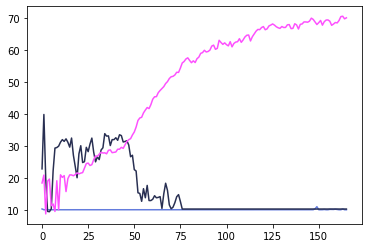

ROUND 165
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.099410


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030540
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.743018

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.938152
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093096
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.355051

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286853
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062219
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064054

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280653
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047196
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.687600

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.868054
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.785238

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.951519
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.088578
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.075758

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.303452
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.073163
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.178407

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.497998
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.842387
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.035087

Power Allocated= 2.605692174016901
CSI= 0.5

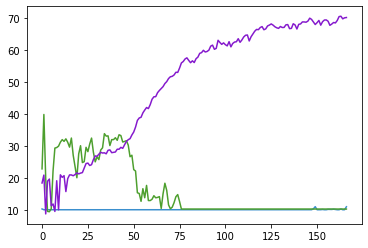

ROUND 166
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.159409


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039326
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238116

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.967361
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050454
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067976

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289144
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149883
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086527

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268449
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237670
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.608712

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.522985
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.980980

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.894016
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.083708
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.157567

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.588154
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.102849
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.143675

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.707804
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.856092
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.893062

Power Allocated= 2.605692174016901
CSI= 0.5

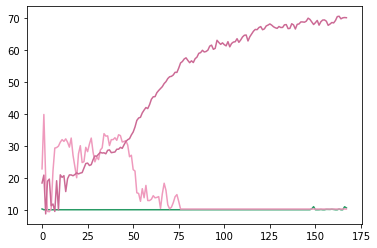

ROUND 167
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.961288


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053311
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029173

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228525
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091902
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074280

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289433
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.425863
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080308

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.937312
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285101
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.618784


Test set: Average loss for Cluster1 model: 138.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.613890
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.823454

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 54.917610
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.365793
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.990623

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.071857
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.053392
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.067094

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.082650
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.816753
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 9.032428

Power Allocated= 2.605692174016901
CSI= 0.5

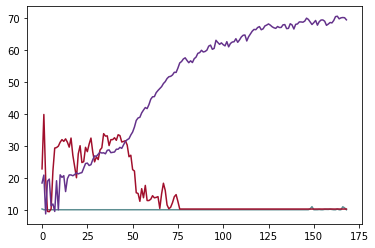

ROUND 168
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.109825


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.295487
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265514

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.939117
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188007
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 4.965507

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300122
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111556
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.545107

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.929675
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.594934
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.029676

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.029900
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.047073
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.084795

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 41.168648
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.027195
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.379781

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.628129
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.753545
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.781143

Power Allocated= 2.605692174016901
CSI= 0.5

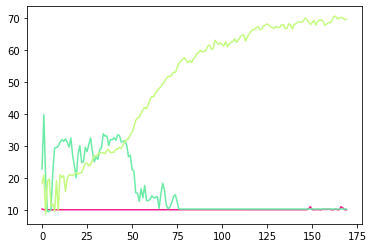

ROUND 169
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.095836


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015799
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063384

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.957604
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195898
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.512015

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213673
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.364911
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.411448

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272394
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.336996
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203838

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.847405
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.667774

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.175663
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.039408
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.112371

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.625809
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.040963
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.162111

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.677988
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.839820
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 16.418789

Power Allocated= 2.605692174016901
CSI= 0.

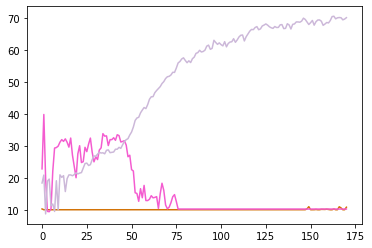

ROUND 170
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.101447


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.664581
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.463706

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.028481
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.226090
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.434795

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.197434
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.382604
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.601703

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293748
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126356
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177904

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.497365
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.673468

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 48.779137
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.002090
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.011536

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.855343
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.064685
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.226792

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.379905
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.109628
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.037267

Power Allocated= 2.605692174016901
CSI= 0.5

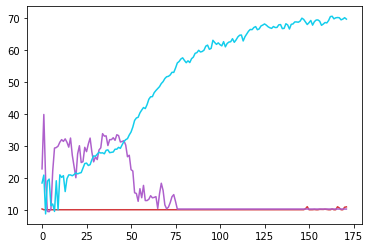

ROUND 171
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.066013


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058254
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.548821

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.978471
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176697
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173419

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294265
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.474177
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007924

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.326832
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042346
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082917

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.445190
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.587894

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.086647
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.070268
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.127031

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.330652
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.041304
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.153713

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.550665
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.047004
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.077680

Power Allocated= 2.605692174016901
CSI= 0.5

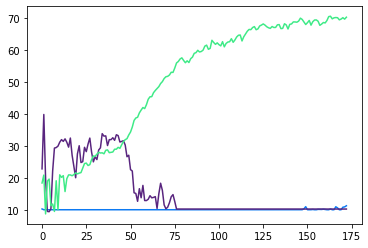

ROUND 172
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.110570


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103472
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014024

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.001221
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210632
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139599

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217839
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140330
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.882071

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286738
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000443
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054771

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.594465
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.456516

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.253826
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.058369
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.130507

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.893845
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.111802
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.019115

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.575646
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.120166
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.995382

Power Allocated= 2.605692174016901
CSI= 0.5

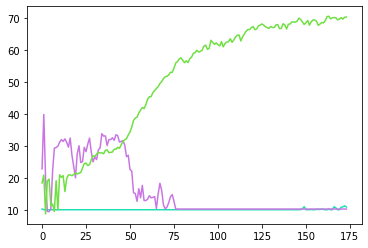

ROUND 173
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.120460


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029491
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.312207

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.973784
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189593
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077855

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272495
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111978
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.331614

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.937294
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.472111
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.747039

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.633305
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059966
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.049716

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 23.664585
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.050976
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.075247

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.044865
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.125798
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.008952

Power Allocated= 2.605692174016901
CSI= 0.5

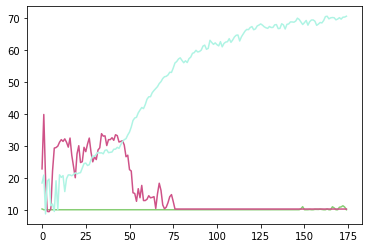

ROUND 174
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.103562


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045752
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.689774

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.999817
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068442
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035257

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288190
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022776
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030703

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.955083
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.743551
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349671

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.933758
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.075019
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.149551

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 32.206100
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077356
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038424

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.229587
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.000279
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.136079

Power Allocated= 2.605692174016901
CSI= 0.5

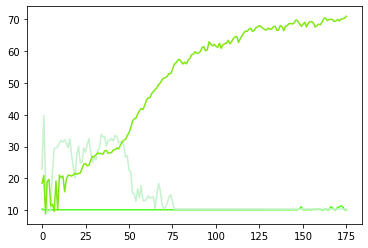

ROUND 175
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.085186


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040250
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119332

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.971898
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086952
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018136

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293727
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074805
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080662

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.844429
Model client

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.469244
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.846014

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.309784
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.037856
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.070623

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 25.340834
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.045778
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.320191

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.077425
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.941971
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.031304

Power Allocated= 2.605692174016901
CSI= 0.5

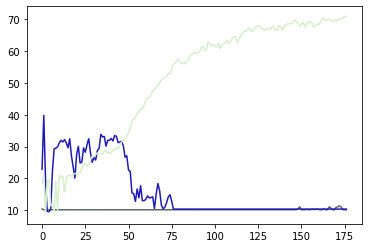

ROUND 176
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.191506


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061026
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120347

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.983799
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013571
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079214

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.189962
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263245
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.809721

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295400
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115764
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.133029

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278348
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.201766

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.657322
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.037694
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.036530

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 22.739346
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.058716
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.240100

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.719049
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.110366
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.113356

Power Allocated= 2.605692174016901
CSI= 0.5

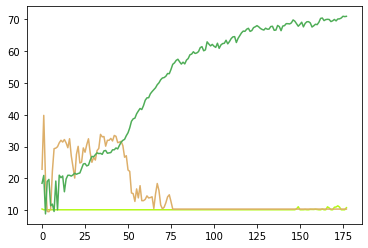

ROUND 177
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.085160


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110561
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113946

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.968182
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124538
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083331

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.201607
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115859
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105257

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292027
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001960
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092156

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.559056
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.759733

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.932388
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.037399
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.113371

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.491755
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.043122
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.115508

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.782624
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.147795
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.007485

Power Allocated= 2.605692174016901
CSI= 0.5

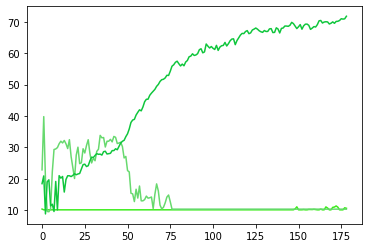

ROUND 178
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.096670


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038287
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004109

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.954804
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054759
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113210

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223184
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102703
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252504

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276411
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.387933
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050365

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.623190
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.790261

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.642464
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.052513
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.234444

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 38.727505
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.091099
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.066924

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.825495
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.066485
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.208786

Power Allocated= 2.605692174016901
CSI= 0.5

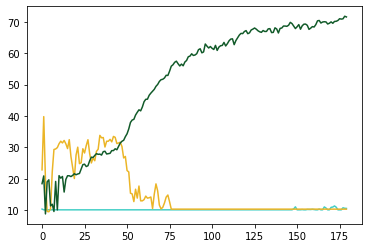

ROUND 179
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.094431


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.360087
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.555080

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.989102
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074253
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060092

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.209984
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212042
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.264683

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287269
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132549
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.079834

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.646611
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.833674

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 47.017853
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087391
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.050422

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.632408
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071697
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.098082

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.443847
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.178828
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.181145

Power Allocated= 2.605692174016901
CSI= 0.5

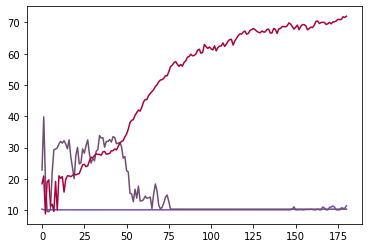

ROUND 180
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.027439


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.229949
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072634

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.965313
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074997
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014569

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239644
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055727
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.187588

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263483
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009832
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.318967

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.616238
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.739349

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.463272
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.023290
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.002256

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 34.620499
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.129144
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.167628

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.444044
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.172327
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.305517

Power Allocated= 2.605692174016901
CSI= 0.5

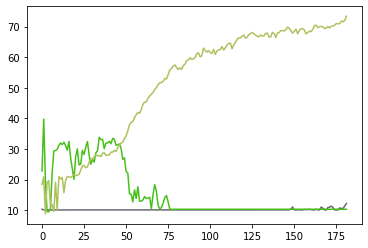

ROUND 181
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.076007


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.488685
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237197

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.985584
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069784
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.712924

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.243513
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073000
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.772643

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247622
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096446
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.304200

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.593790
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.704463

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.222569
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079970
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.017060

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.530426
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.120336
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.224253

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 14.374123
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.093821
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.081068

Power Allocated= 2.605692174016901
CSI= 0.

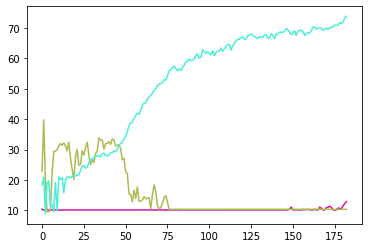

ROUND 182
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.046521


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090841
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243954

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.959686
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140339
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126101

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.256500
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263359
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.400546

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291172
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142685
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173169

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.740167
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.928091

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.192051
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.072851
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.109977

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.345890
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.085010
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.284380

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.992405
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.188943
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.155228

Power Allocated= 2.605692174016901
CSI= 0.5

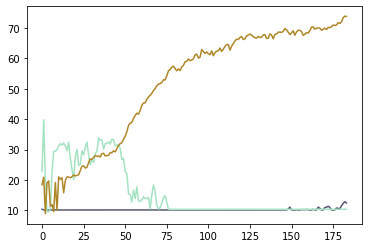

ROUND 183
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.123326


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205626
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.983718

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.006010
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110989
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.771224

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196690
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179604
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276277

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277227
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136448
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017032

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.142896
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.835403

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 36.082989
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.033297
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.204605

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 28.235210
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.098973
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.196067

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.548149
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.310849
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.033290

Power Allocated= 2.605692174016901
CSI= 0.5

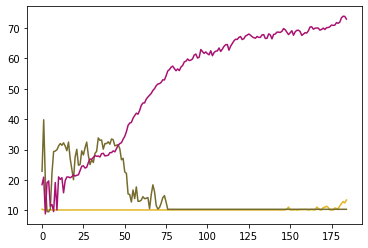

ROUND 184
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.047162


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000923
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181609

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.964237
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146150
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134771

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.218601
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260866
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129326

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.279096
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154240
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.461281

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.926001
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.926584

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.822859
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.079574
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.069355

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.398094
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.057356
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.126856

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.599387
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.895864
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.160530

Power Allocated= 2.605692174016901
CSI= 0.5

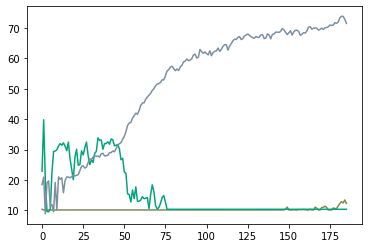

ROUND 185
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.095387


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199597
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323086

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.993689
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071700
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094902

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253604
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134954
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005956

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274870
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161871
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.706825

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.168731
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.300017

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 46.850674
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.083034
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.181016

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.829571
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.085101
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.122486

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.307726
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087444
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.121328

Power Allocated= 2.605692174016901
CSI= 0.5

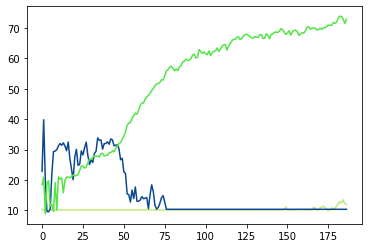

ROUND 186
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.040207


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088320
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.839375

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.978844
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093439
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099421

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238986
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164708
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.767240

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252316
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060031
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045702

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.830007
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.794662

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 51.372772
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.067724
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.150751

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.514858
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.083196
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.210470

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.337150
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.199806
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.126165

Power Allocated= 2.605692174016901
CSI= 0.5

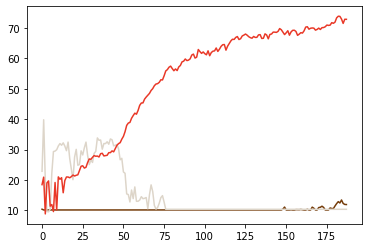

ROUND 187
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.056629


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201085
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272512

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.808998
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020452
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091378

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198602
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014255
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040678

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251904
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005126
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129911

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.553172
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.757910

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 35.996246
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087003
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.943354

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.682770
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.072369
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.973171

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.935886
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.835439
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.230600

Power Allocated= 2.605692174016901
CSI= 0.5

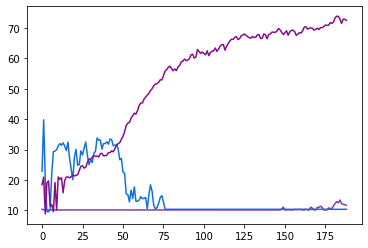

ROUND 188
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206962


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059037
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134029

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.942974
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019311
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023407

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227889
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034095
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566660

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258853
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156112
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037599

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.631792
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.724175

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.215641
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.063888
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038265

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.579170
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.104998
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.095348

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.840995
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.244277
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.107350

Power Allocated= 2.605692174016901
CSI= 0.5

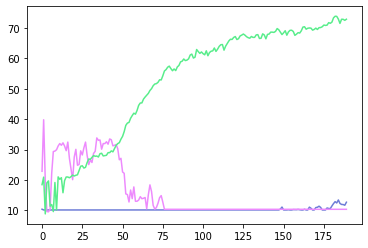

ROUND 189
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.921526


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137562
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.585200

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240012
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056205
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019349

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.945916
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.650726
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016754


Test set: Average loss for Cluster1 model: 58.0578, Accuracy: 1010/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.767660
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.957130

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 59.374119
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.054345
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.102709

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.543020
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.080526
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.097304

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.024548
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.404934
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.033661

Power Allocated= 2.605692174016901
CSI= 0.5

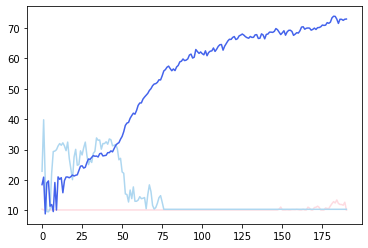

ROUND 190
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.077695


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170828
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.225732

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.966821
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101898
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.000229

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251091
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165504
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.765434

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271496
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166424
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.603202

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.860818
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.941278

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 44.367779
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.082232
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.986613

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 26.310284
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.101007
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.046088

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 6.410324
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.103431
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.333303

Power Allocated= 2.605692174016901
CSI= 0.5

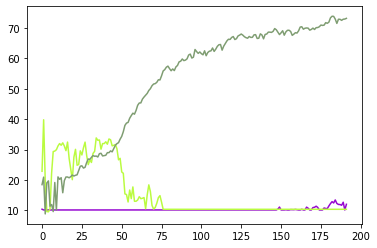

ROUND 191
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.940805


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078980
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229751

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263643
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209075
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.813547

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.866546
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126013
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002888


Test set: Average loss for Cluster1 model: 60.7753, Accuracy: 1013/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.845067
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.898854

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 48.257988
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.054345
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.046215

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 29.671091
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.077136
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.214722

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.375551
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.462273
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.161224

Power Allocated= 2.605692174016901
CSI= 0.5

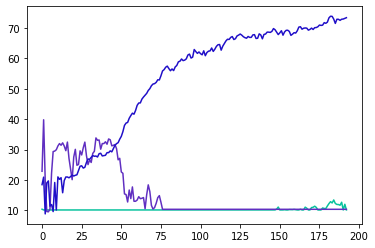

ROUND 192
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.107114


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054732
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032844

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.061445
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002742
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022814

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270104
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007302
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.796681

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275995
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168112
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.421614

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.243988
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.020940

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 43.942673
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.075590
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.955583

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 25.116623
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.046085
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.315137

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 5.488163
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.392050
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.126828

Power Allocated= 2.605692174016901
CSI= 0.5

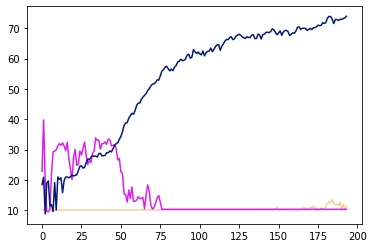

ROUND 193
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.064182


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123923
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051020

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.890673
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021321
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.684406

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.167086
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.391512
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151324

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278931
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059412
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.415557

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.895497
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.932084

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.786362
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.054160
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.880695

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.454065
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.065486
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.141355

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 8.233589
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.134841
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.267143

Power Allocated= 2.605692174016901
CSI= 0.5

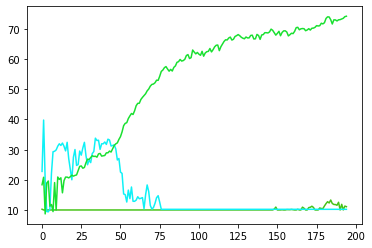

ROUND 194
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.161193


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117355
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.784693

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.010992
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080923
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022566

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203871
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.557614
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.939393

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.284618
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132591
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060853

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.819820
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.946021

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 37.703793
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.026596
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.193577

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 19.662363
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.087788
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.309358

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 4.442896
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.108088
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.001284

Power Allocated= 2.605692174016901
CSI= 0.5

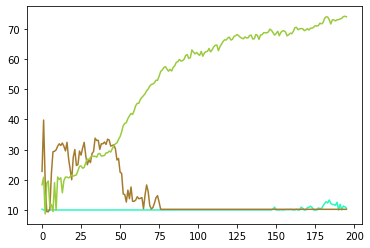

ROUND 195
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.122513


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.333404
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277977

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.995250
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020214
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058729

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212792
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142779
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.524381

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280101
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025143
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137915

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.804414
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.861512

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 31.133602
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.047215
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.032409

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 40.316319
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.047866
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.337608

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 10.020192
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.107622
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.032660

Power Allocated= 2.605692174016901
CSI= 0.

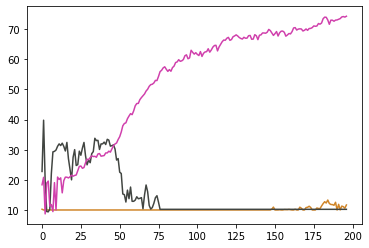

ROUND 196
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.868993


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093980
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054582

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223026
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116343
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095768

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.921908
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291012
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.601129


Test set: Average loss for Cluster1 model: 38.5082, Accuracy: 1029/10000 (10%)

0.2292599999999775
Power Allocated= 3.068377343801315
CSI= 0.7731066781536989
SNR= 27

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.111761
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.866133

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 39.439716
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.084277
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.124198

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 27.119335
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.107353
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.089295

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.824756
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.177870
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.016034

Power Allocated= 2.605692174016901
CSI= 0.5

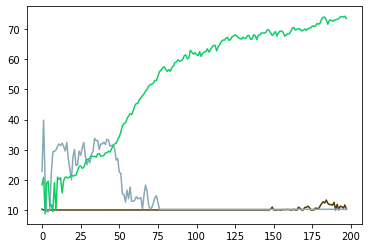

ROUND 197
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.987103


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092100
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094642

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198315
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405856
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.932460

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255306
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043248
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.300548

Power Allocated= 14.61209066897171
CSI= 0.5563305463787511
SNR= 36.48459443738103
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.928879
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241977
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.806693


Test set: Average loss for Cluster1 model: 131.

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.684623
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.875205

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.876984
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.035672
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.013185

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 45.043522
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.112461
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.396818

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.287946
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.541867
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.974217

Power Allocated= 2.605692174016901
CSI= 0.5

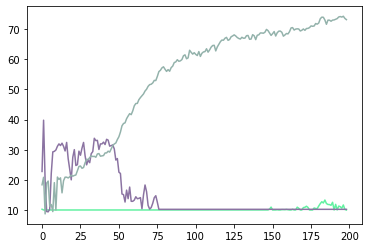

ROUND 198
0.060939999999998856
Power Allocated= 11.801839602592597
CSI= 0.21702596500884852
SNR= 24.142338023266703
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.099897


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.267090
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088376

Power Allocated= 11.85072623240758
CSI= 0.2193532299559593
SNR= 33.67183204979048
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.895776
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.318992
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193346

Power Allocated= 13.080683012793166
CSI= 0.30039951479118854
SNR= 22.481666147300032
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246032
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070115
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153725

Power Allocated= 8.666354407711896
CSI= 0.12914509273401698
SNR= 35.41237699676323
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.242408
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028113
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059452

Power Allocated= 14.61209066897171
CSI= 0.5563305463

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.640028
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.751678

Power Allocated= 0.9839213104167683
CSI= 0.29603853780940836
SNR= 21.197263385790702
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 42.604618
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.046563
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.213912

Power Allocated= 3.0334090513727427
CSI= 0.7527564932086445
SNR= 26.630643147372865
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 33.245358
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.082356
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.300994

Power Allocated= 3.210478687463587
CSI= 0.868522077366592
SNR= 22.735898227405954
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 3.157451
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.046583
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.983351

Power Allocated= 2.605692174016901
CSI= 0.5

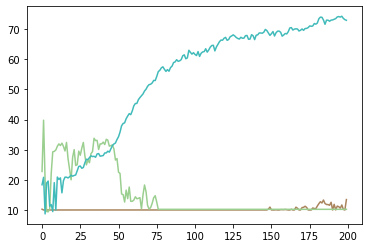

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
    
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[10.35, 22.85, 18.44], [10.1, 39.81, 20.91], [10.1, 19.8, 8.8], [10.1, 9.58, 19.0], [10.1, 9.49, 19.67], [10.1, 10.38, 11.35], [10.1, 22.2, 11.9], [10.1, 29.33, 9.57], [10.1, 29.5, 19.15], [10.1, 29.94, 10.08], [10.1, 31.17, 20.99], [10.1, 31.97, 20.2], [10.1, 31.42, 20.73], [10.1, 32.21, 15.77], [10.1, 31.15, 19.79], [10.1, 29.63, 20.96], [10.1, 32.46, 20.96], [10.1, 27.08, 20.7], [10.1, 23.57, 21.08], [10.1, 20.08, 21.61], [10.1, 27.54, 21.28], [10.1, 30.07, 21.53], [10.1, 24.82, 21.68], [10.1, 25.09, 23.12], [10.1, 29.57, 24.51], [10.1, 28.22, 24.65], [10.1, 30.59, 23.9], [10.1, 32.45, 24.16], [10.1, 28.06, 25.72], [10.1, 25.04, 26.89], [10.1, 26.6, 26.78], [10.1, 25.75, 27.43], [10.1, 28.73, 28.01], [10.1, 29.42, 27.79], [10.1, 33.83, 27.86], [10.1, 33.06, 27.55], [10.1, 33.14, 28.64], [10.1, 30.12, 28.77], [10.1, 31.97, 27.9], [10.1, 31.97, 28.02], [10.1, 32.56, 28.11], [10.1, 31.76, 28.98], [10.1, 33.49, 28.98], [10.1, 33.22, 29.56], [10.1, 31.23, 29.25], [10.1, 31.4, 30.36], [1